In [1]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

## Imports

In [2]:
import os
import sys
import scipy
import lightgbm
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

pd.set_option('display.float.format', lambda x: '%.3f' % x)

In [3]:
df_model = pd.read_excel('efundementals_tesco_data_complete.xlsx')
print(df_model.shape)

(26091, 78)


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to your categorical data and transform it
df_model["AV_OOS"] = label_encoder.fit_transform(df_model["AV_OOS"])

In [5]:
exclude_cols = ["RETAILER",
      "SR_count",
      "FB_FEEDBACK_RECOMMENDATION",
      # "FB_FEEDBACK_COMMENT_COUNT",
      # "FB_FEEDBACK_AVG_RATING",
      "COMP_SCORE_WSP_INC_VAT",
      "COMP_SCORE_WSP_VAT",
      "COMP_SCORE_WSP_POR",
      "COMP_SCORE_WSP_RSP",
      "COMP_SCORE_COUNTRY",
      "COMP_SCORE_PRICE",
      "COMP_SCORE_MANUFACTURER",
      "COMP_SELLER_TYPE",
      # "COMP_VIDEO_COUNT",
      "COMP_SCORE_STORAGE",
      # "COMP_IMG_COUNT",
      "COMP_SCORE_DESCRIPTION",
      # "COMP_HAS_RICH_CONTENT",
      "COMP_SCORE_INGREDIENTS",
      "COMP_SCORE_NET_QUANTITY",
      "COMP_SCORE_NAME",
      "COMP_SCORE_NUTRITION",
      "COMP_BASICS_SCORE",
      "COMP_COMPLIANCE_SCORE",
      # "PR_SUBSCRIPTION",
      # "RETAIL_SALES_VALUE",
      # "RETAIL_SALES_UNIT",
      "NIELSEN_END_DATE",
#       "EAN",
      "MANUFACTURER",
      "WEEK_ENDING_DATE",
      "SR_AVG_RANK",
      # 'LAST_2_WEEK_SALES',
      # "LAST_4_WEEK_SALES",
      # 'LAST_16_WEEK_SALES',
      # "SEARCH_TERM_IN_DESC",
      # "SEARCH_TERM_IN_NAME",
      "SEARCH_TERM_EXACT_POS_IN_TITLE",
      "Spends",
      "HOL_PRE",
      "HOL_POST",
      "HOL_FORT",
      # "HOLIDAY_FLAG",
      "SHARE_OF_SALES","RETAILER_MARGIN_PERCENT","SEARCH_TERM_LENGTH","DAY_OF_WEEK","GRAMMAGE", 'Seasonal_sku','SEARCH_TERM_WORD_COUNT', 'COMP_SCORE_IMAGE','SEARCH_TERM_IN_DESC_FW_SCORE','CHRISTMAS','EASTER','HALLOWEEN','VALENTINE',
                'SEARCH_TERM_IN_TITLE_FW_SCORE','WEEK_OF_YEAR']

include_cols = ['SR_RANK','SR_PARSED_PRICE','COMP_TITLE_LENGTH','COMP_DESCRIPTION_LENGTH',
                "COMP_IMG_COUNT", "RETAIL_SALES_VALUE", "RETAIL_SALES_UNIT",
                'SEARCH_TERM_IN_NAME',"SEARCH_TERM_IN_DESC",'SEARCH_TERM_COUNT_IN_NAME','SEARCH_TERM_COUNT_IN_DESC','SEARCH_TERM_FW_POS_IN_TITLE', 'Retailer_Margin','LAST_1_WEEK_SALES',
                'LAST_2_WEEK_SALES',
      "LAST_4_WEEK_SALES","LAST_8_WEEK_SALES",
      'LAST_16_WEEK_SALES',"HOLIDAY_FLAG",
      "FB_FEEDBACK_COMMENT_COUNT",
      "FB_FEEDBACK_AVG_RATING",'AV_OOS'

      #  'PACK_TYPE_Boxed Chocolate', 'PACK_TYPE_Multipack',
      #  'PACK_TYPE_Packaged', 'PACK_TYPE_Premium Selection',
      #  'PACK_TYPE_Single','PR_SUBSCRIPTION_NOT AVAILABLE'

      
      # 'BRAND','AV_OOS', 'PACK_TYPE',"PR_SUBSCRIPTION"
                ## columns commented by sahil
#                 'Last 30 days paid_count',
#        'Days_since_last_paid',"NO_PROMOTION",'Last 30 days promotion_count', 'Days_since_last_promotion',
      #  'LAST_1_WEEK_SALES_new', 'LAST_8_WEEK_SALES_new',
      #  'LAST_16_WEEK_SALES_new',
      #  "Discount_Depth_tmp"
      #  'COUPON_PROMOTION','Clubcard_flag',
      #  'PRICE_CUT_PROMOTION', 'BUNDLE_PROMOTION'
                #,'CATEGORY',"SR_PAID_SEARCH","SR_PROMOTION_TYPE", 'Last 30 days_continous','LAST_16_WEEK_SALES'
]



In [638]:
# exclude_cols = ["RETAILER",
#       "SR_count",
#       "FB_FEEDBACK_RECOMMENDATION",
#       "FB_FEEDBACK_COMMENT_COUNT",
#       "FB_FEEDBACK_AVG_RATING",
#       "COMP_SCORE_WSP_INC_VAT",
#       "COMP_SCORE_WSP_VAT",
#       "COMP_SCORE_WSP_POR",
#       "COMP_SCORE_WSP_RSP",
#       "COMP_SCORE_COUNTRY",
#       "COMP_SCORE_PRICE",
#       "COMP_SCORE_MANUFACTURER",
#       "COMP_SELLER_TYPE",
#       "COMP_VIDEO_COUNT",
#       "COMP_SCORE_STORAGE",
#       "COMP_IMG_COUNT",
#       "COMP_SCORE_DESCRIPTION",
#       "COMP_HAS_RICH_CONTENT",
#       "COMP_SCORE_INGREDIENTS",
#       "COMP_SCORE_NET_QUANTITY",
#       "COMP_SCORE_NAME",
#       "COMP_SCORE_NUTRITION",
#       "COMP_BASICS_SCORE",
#       "COMP_COMPLIANCE_SCORE",
#       "PR_SUBSCRIPTION",
#       "RETAIL_SALES_VALUE",
#       "RETAIL_SALES_UNIT",
#       "NIELSEN_END_DATE",
# #       "EAN", sahil
#       "MANUFACTURER",
#       "WEEK_ENDING_DATE",
#       "SR_AVG_RANK",
#       'LAST_2_WEEK_SALES',
#       "LAST_4_WEEK_SALES",
#       'LAST_16_WEEK_SALES',
#       "SEARCH_TERM_IN_DESC",
#       "SEARCH_TERM_IN_NAME",
#       "SEARCH_TERM_EXACT_POS_IN_TITLE",
#       "Spends",
#       "HOL_PRE",
#       "HOL_POST",
#       "HOL_FORT",
#       "HOLIDAY_FLAG","SHARE_OF_SALES","RETAILER_MARGIN_PERCENT","SEARCH_TERM_LENGTH","DAY_OF_WEEK","GRAMMAGE", 'Seasonal_sku','SEARCH_TERM_WORD_COUNT']

# include_cols = ['SR_RANK','SR_PARSED_PRICE','COMP_SCORE_IMAGE','COMP_TITLE_LENGTH','COMP_DESCRIPTION_LENGTH',
#                 'SEARCH_TERM_COUNT_IN_NAME','SEARCH_TERM_COUNT_IN_DESC','CHRISTMAS','EASTER','HALLOWEEN','VALENTINE',
#                 'SEARCH_TERM_IN_TITLE_FW_SCORE','SEARCH_TERM_IN_DESC_FW_SCORE','SEARCH_TERM_FW_POS_IN_TITLE',
#                 'WEEK_OF_YEAR','AV_OOS','BRAND', 'PACK_TYPE', 'Retailer_Margin',
#                 ## columns commented by sahil
# #                 'Last 30 days paid_count',
# #        'Days_since_last_paid',"NO_PROMOTION",'Last 30 days promotion_count', 'Days_since_last_promotion',
# #        'LAST_1_WEEK_SALES_new', 'LAST_8_WEEK_SALES_new',
# #        'LAST_16_WEEK_SALES_new',"Discount_Depth_tmp"
#       #  'COUPON_PROMOTION','Clubcard_flag',
#       #  'PRICE_CUT_PROMOTION', 'BUNDLE_PROMOTION'
#                 #,'CATEGORY',"SR_PAID_SEARCH","SR_PROMOTION_TYPE", 'Last 30 days_continous','LAST_16_WEEK_SALES'
# ]



In [7]:
#Check any cols missed 
print('Columns Missed:',set(df_model.columns)-set(include_cols)-set(exclude_cols))

Columns Missed: {'GATHERED_DATE', 'SR_PAID_SEARCH', 'COMP_HAS_RICH_CONTENT', 'COMP_RETAILER_PRODUCT_NAME', 'COMP_VIDEO_COUNT', 'PR_SUBSCRIPTION', 'PACK_TYPE', 'SR_SEARCH_TERM', 'SR_PROMOTION_TYPE', 'BRAND', 'Clubcard_flag', 'GTIN', 'COMP_DESCRIPTION'}


In [8]:
#Drop Exclude columns
df_model.drop(columns=exclude_cols,inplace=True)

In [9]:
df_model.shape

(26091, 35)

In [10]:
df_model.head(3)

,GTIN,GATHERED_DATE,SR_SEARCH_TERM,SR_PAID_SEARCH,SR_RANK,BRAND,SR_PARSED_PRICE,FB_FEEDBACK_AVG_RATING,COMP_HAS_RICH_CONTENT,COMP_VIDEO_COUNT,...,Retailer_Margin,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,LAST_1_WEEK_SALES,LAST_2_WEEK_SALES,LAST_4_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,SEARCH_TERM_FW_POS_IN_TITLE
0,GTIN1,2022-01-11,funsize,0,3,Brand1,1.490,3.700,0,0,...,0.344,12022.810,8069,14704,18258,31239,57090,347313,0,2
1,GTIN1,2022-05-10,funsize,0,3,Brand1,2.200,3.700,0,0,...,0.428,12086.800,5494,9844,13362,19692,36922,107899,0,2
2,GTIN1,2022-03-09,funsize,0,3,Brand1,3.000,3.700,0,0,...,0.494,18222.000,7273,22697,37471,52987,79046,128067,0,2


In [11]:
deciles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.95,0.99,1]
for i in df_model.columns:
    if i in include_cols:
        print(i)
        print(df_model[i].quantile(deciles))




SR_RANK
0.100    2.000
0.200    3.000
0.300    5.000
0.400    8.000
0.500   12.000
0.600   15.000
0.700   18.000
0.800   20.000
0.900   23.000
0.950   24.000
0.990   26.000
1.000   26.000
Name: SR_RANK, dtype: float64
SR_PARSED_PRICE
0.100   1.240
0.200   1.250
0.300   1.250
0.400   1.350
0.500   1.500
0.600   1.990
0.700   2.250
0.800   3.000
0.900   3.500
0.950   5.000
0.990   5.000
1.000   7.000
Name: SR_PARSED_PRICE, dtype: float64
FB_FEEDBACK_AVG_RATING
0.100   2.700
0.200   3.400
0.300   4.000
0.400   4.100
0.500   4.400
0.600   4.700
0.700   4.800
0.800   5.000
0.900   5.000
0.950   5.000
0.990   5.000
1.000   5.000
Name: FB_FEEDBACK_AVG_RATING, dtype: float64
COMP_IMG_COUNT
0.100   1.000
0.200   1.000
0.300   1.000
0.400   1.000
0.500   1.000
0.600   1.000
0.700   1.000
0.800   1.000
0.900   3.000
0.950   4.000
0.990   4.000
1.000   5.000
Name: COMP_IMG_COUNT, dtype: float64
COMP_TITLE_LENGTH
0.100   22.000
0.200   25.000
0.300   26.000
0.400   29.000
0.500   30.000
0.600   33.

In [12]:
# Null to 0
# df_model.loc[:,'oos'] = df_model['oos'].fillna(100)
# df_model.loc[:,'Promotion'] = df_model['Promotion'].fillna('NA')
#cat_cols=['AV_OOS_AVAILABLE', 'AV_OOS_OOS'
      #  'PACK_TYPE_Boxed Chocolate', 'PACK_TYPE_Multipack',
      #  'PACK_TYPE_Packaged', 'PACK_TYPE_Premium Selection',
      #  'PACK_TYPE_Single','PR_SUBSCRIPTION_NOT AVAILABLE'
      #  'AV_OOS', 'PACK_TYPE',
          #'BRAND','CATEGORY','SR_PAID_SEARCH'
          #]
# na_cols=list((df_model.isna().sum())[(df_model.isna().sum()>0).values].index)
# df_model[na_cols]=df_model[na_cols].fillna(0.0)

# for c in cat_cols :
#   df_model.loc[:, c] = pd.Series(df_model.loc[:, c], dtype="category") # commented by sahil
df_model.loc[:, "GTIN"] = pd.Series(df_model["GTIN"].astype(str), dtype="category")
#num_cols = df_model.columns[df_model.dtypes == np.float]
#df_model[num_cols] = df_model[num_cols].fillna(0)
# Taking Log of Target Variable
#df_model.loc[:, "Dependent"] = np.log(df_model.loc[:, "Dependent"])
df_model.isna().sum()

GTIN                              0
GATHERED_DATE                     0
SR_SEARCH_TERM                    0
SR_PAID_SEARCH                    0
SR_RANK                           0
BRAND                             0
SR_PARSED_PRICE                   2
FB_FEEDBACK_AVG_RATING          431
COMP_HAS_RICH_CONTENT             0
COMP_VIDEO_COUNT                  0
COMP_IMG_COUNT                    0
COMP_TITLE_LENGTH                 0
COMP_DESCRIPTION_LENGTH           0
FB_FEEDBACK_COMMENT_COUNT       431
SR_PROMOTION_TYPE                 0
Clubcard_flag                     0
COMP_RETAILER_PRODUCT_NAME        0
COMP_DESCRIPTION                  0
AV_OOS                            0
PR_SUBSCRIPTION                  26
SEARCH_TERM_IN_NAME               0
SEARCH_TERM_COUNT_IN_NAME         0
SEARCH_TERM_IN_DESC               0
SEARCH_TERM_COUNT_IN_DESC         0
PACK_TYPE                      1341
Retailer_Margin                   0
RETAIL_SALES_VALUE                0
RETAIL_SALES_UNIT           

In [13]:
def print_metrics(actual, prediction):
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(actual, prediction)
  r2 = r2_score(actual, prediction)
  adjusted_r2 = 1 - (1 - r2) * (len(actual) - 1) / (len(actual) - model_x_train.shape[1] - 1)
  mae = mean_absolute_error(actual, prediction)
  mape = np.mean(np.abs(actual - prediction)/actual)
  wmape = np.sum(np.abs(actual - prediction))/actual.sum()
  # print(f"r2\t: {r2:.4f}\nAdj R2\t: {adjusted_r2:.4f}\n")
  print(f"MAE\t: {mae:.4f}\nMAPE\t: {mape:.4f}\nW-MAPE\t: {wmape:.4f}\nR2\t: {r2:.4f}")

In [14]:
# GRID SEARCH
def get_best_params(model_x_train, model_y_train):
    from sklearn.model_selection import GridSearchCV

    model = lightgbm.LGBMRegressor()

    param_dist = {
      "max_depth"           : np.arange(7, 12, 1),
      "learning_rate"       : np.arange(0.02, 0.06, 0.004),
      "num_leaves"          : [32,40,56,64,128,256],
      "n_estimators"        : np.arange(500, 600, 10),

      "boosting_type"       : ["gbdt"],
      "random_state"        : [42],
      "objective"           : ["regression"]
      # these parameters are commented by sahil

      # "max_depth"           : np.arange(7, 12, 1),
      # "learning_rate"       : np.arange(0.02,0.06),
      # "num_leaves"          : [32,40],
      # "n_estimators"        : np.arange(500,600,10),

      # "boosting_type"       : ["gbdt"],
      # "random_state"        : [42],
      # "objective"           : ["regression"]

      # "max_bin"             : [64,128,256],
      # "learning_rate"       : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.2],
      # "num_leaves"          : np.logspace(start= 1, stop =10,  num=10, base=2),
      # "max_bin"             : np.logspace(start= 1, stop =8,  num=8, base=2),
      # "min_child_samples"   : np.arange(10, 100, 10),
      # "colsample_bytree"    : np.arange(.1, 1, .1),
      # "min_data_in_leaf"    : []
    }

    grid_search = GridSearchCV(model, param_grid=param_dist, verbose = 10, n_jobs = -1, cv = 3)
    grid_search.fit(model_x_train, model_y_train)
    print("max_depth_best:\t",grid_search.best_estimator_.max_depth)
    print("num_leaves_best:\t",grid_search.best_estimator_.num_leaves)
    print("learning_rate_best:\t",grid_search.best_estimator_.learning_rate)
    print("n_estimators_best:\t",grid_search.best_estimator_.n_estimators)

    #print("max_bin_best:\t",grid_search.best_estimator_.max_bin)
    print("min_child_samples_best:\t", grid_search.best_estimator_.min_child_samples)
    print("colsample_bytree_best:\t", grid_search.best_estimator_.colsample_bytree)
    return grid_search.best_estimator_.max_depth,grid_search.best_estimator_.num_leaves,grid_search.best_estimator_.learning_rate,grid_search.best_estimator_.n_estimators

In [15]:
independent_model_cols=include_cols.copy()
dependent_cols = 'SR_RANK'
independent_model_cols.remove(dependent_cols)
X,y = df_model[independent_model_cols],df_model[dependent_cols]
print('X:',type(X),X.shape)
print('Y:',type(y),y.shape)
y.head()

X: <class 'pandas.core.frame.DataFrame'> (26091, 21)
Y: <class 'pandas.core.series.Series'> (26091,)


0    3
1    3
2    3
3    3
4    3
Name: SR_RANK, dtype: int64

In [16]:
#best_parameters=[10, 32, 0.045000000000000005, 590]
# best_parameters=[7, 40,0.042, 590]
#best_parameters=[9, 32, 0.05600000000000001, 590]
best_parameters=[9, 40, 0.05600000000000001, 590]

In [17]:
X.head()

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_IMG_COUNT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,SEARCH_TERM_COUNT_IN_NAME,SEARCH_TERM_COUNT_IN_DESC,...,Retailer_Margin,LAST_1_WEEK_SALES,LAST_2_WEEK_SALES,LAST_4_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS
0,1.490,30,366,1,12022.810,8069,0,0,0,0,...,0.344,14704,18258,31239,57090,347313,0,11.000,3.700,0
1,2.200,30,366,1,12086.800,5494,0,0,0,0,...,0.428,9844,13362,19692,36922,107899,0,13.000,3.700,0
2,3.000,30,366,1,18222.000,7273,0,0,0,0,...,0.494,22697,37471,52987,79046,128067,0,13.000,3.700,0
3,3.000,30,366,1,14210.640,4755,0,0,0,0,...,0.673,13198,21267,31456,60040,232850,0,11.000,3.700,0
4,3.000,30,366,1,13047.000,4349,1,1,1,1,...,-1.824,8716,13083,35780,70862,124792,1,13.000,3.700,0


In [18]:
# HashMap of Models
model_dict={}
# To Store actual vs predicted results
predictions_df_master=pd.DataFrame()
# To Store Feature Importance returned by LightGBM 
f_imp_master=pd.DataFrame()
# To Store MAPE and RSq and model summary
error_df_master=pd.DataFrame()
# To Store Feature Importance based on set one feature zero method
df_imp_master = pd.DataFrame()

X_model = X.copy()
y_model = y.copy()
model_x_train, model_x_test, model_y_train, model_y_test = train_test_split(X_model,y_model,test_size=0.2,random_state=42)


negative_corelation = ["SEARCH_TERM_COUNT_IN_NAME",
                       "SEARCH_TERM_COUNT_IN_DESC","COMP_SCORE_IMAGE","SEARCH_TERM_IN_DESC_FW_SCORE","SEARCH_TERM_IN_TITLE_FW_SCORE",
                       "SHARE_OF_SALES","COMP_DESCRIPTION_LENGTH",'Last 30 days paid_count',"COMP_TITLE_LENGTH","NO_PROMOTION","Retailer_Margin",'LAST_1_WEEK_SALES_new', 'LAST_8_WEEK_SALES_new',
       'LAST_16_WEEK_SALES_new','Last 30 days promotion_count',"Discount_Depth_tmp"]
      #                  ,'COUPON_PROMOTION',,"LAST_16_WEEK_SALES"
      #  'PRICE_CUT_PROMOTION', 'BUNDLE_PROMOTION']
positive_corelation = [
       'Days_since_last_paid',
  "SR_PARSED_PRICE", 'Days_since_last_promotion']                       

monotone_cols = [(-1 if x in negative_corelation else 1 if x in positive_corelation else 0) for x in model_x_train.columns]
    
params = {
      "objective": "regression",
      "boosting_type": "gbdt",
      "random_state": 42,
      "max_depth": best_parameters[0],
      "num_leaves": best_parameters[1],
      "learning_rate": best_parameters[2],
      "num_iterations": best_parameters[3],
      "monotone_constraints":  monotone_cols,
      "feature_fraction":0.9,
      # "max_bin": 256,
      "min_child_samples": 5, # def=20  
      # "metric": ["l1"],
      # "colsample_bytree": [0.5], # If i have 40 column in train data ; tree will select 50% of columns randomly
}
    
gbm = lightgbm.LGBMRegressor(**params, n_jobs=16,importance_type='gain')
gbm.fit(model_x_train, model_y_train)
model_dict=gbm
y_pred = gbm.predict(model_x_test)
df_predictions = pd.DataFrame({"Actual": model_y_test,"Predicted": y_pred})

# Make predictions 0 where negative
df_predictions.loc[df_predictions["Predicted"] < 0, "Predicted"] = 1
df_predictions["Error"] = df_predictions["Predicted"] - df_predictions["Actual"]
df_predictions['Train_Test'] = "Test"

# df_predictions.head()
print("Error : {0}".format(df_predictions["Error"].abs().sum()))
print(f"{df_predictions.Actual.sum():,.2f}")
print(f"{df_predictions.Predicted.sum():,.2f}")
print(f"Train Prediction Metrics : ")
y_train_pred = gbm.predict(model_x_train)
actual=model_y_train
# Make predictions 0 where negative
prediction=np.where(y_train_pred<=0,1,y_train_pred)
df_predictions_train = pd.DataFrame({"Actual": model_y_train,"Predicted": prediction})
df_predictions_train.loc[df_predictions_train["Predicted"] < 0, "Predicted"] = 1
df_predictions_train["Error"] = df_predictions_train["Predicted"] - df_predictions_train["Actual"]
df_predictions_train['Train_Test'] = "Train"

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(actual, prediction)
r2_train = r2_score(actual, prediction)
adjusted_r2_train = 1 - (1 - r2_train) * (len(actual) - 1) / (len(actual) - model_x_train.shape[1] - 1)
mae_train = mean_absolute_error(actual, prediction)
mape_train = np.mean(np.abs(actual - prediction)/actual)
mape2_train = np.mean(np.abs(actual - prediction))/np.mean(actual)
print('mape2:',mape2_train)
wmape_train = np.sum(np.abs(actual - prediction))/actual.sum()
print_metrics(actual=model_y_train, prediction=y_train_pred)
print(f"Test Prediction Metrics : ")
y_test_pred = gbm.predict(model_x_test)
actual=model_y_test
prediction=y_test_pred
prediction=np.where(y_test_pred<=0,1,y_test_pred)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(actual, prediction)
r2_test = r2_score(actual, prediction)
adjusted_r2_test = 1 - (1 - r2_test) * (len(actual) - 1) / (len(actual) - model_x_test.shape[1] - 1)
mae_test = mean_absolute_error(actual, prediction)
mape_test = np.mean(np.abs(actual - prediction)/actual)
mape2_test = np.mean(np.abs(actual - prediction))/np.mean(actual)
print('mape2:',mape2_test)
wmape_test = np.sum(np.abs(actual - prediction))/actual.sum()
print_metrics(actual=model_y_test, prediction=y_test_pred)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Error : 15408.462359465393
62,637.00
62,334.15
Train Prediction Metrics : 
mape2: 0.22012876974045636
MAE	: 2.6032
MAPE	: 0.5600
W-MAPE	: 0.2202
R2	: 0.7640
Test Prediction Metrics : 
mape2: 0.24599617413773675
MAE	: 2.9538
MAPE	: 0.6205
W-MAPE	: 0.2461
R2	: 0.6993


In [19]:
# import pickle as pk
# with open("lgbm_model2.pkl", "wb") as file: # file is a variable for storing the newly created file, it can be anything.
#     pickle.dump(gbm, file) # Dump function is used to write the object into the created file in byte format.

In [23]:
set(features)-set(independent_model_cols)

{'COMP_HAS_RICH_CONTENT', 'COMP_VIDEO_COUNT'}

In [24]:
independent_model_cols

['SR_PARSED_PRICE',
 'COMP_TITLE_LENGTH',
 'COMP_DESCRIPTION_LENGTH',
 'COMP_IMG_COUNT',
 'RETAIL_SALES_VALUE',
 'RETAIL_SALES_UNIT',
 'SEARCH_TERM_IN_NAME',
 'SEARCH_TERM_IN_DESC',
 'SEARCH_TERM_COUNT_IN_NAME',
 'SEARCH_TERM_COUNT_IN_DESC',
 'SEARCH_TERM_FW_POS_IN_TITLE',
 'Retailer_Margin',
 'LAST_1_WEEK_SALES',
 'LAST_2_WEEK_SALES',
 'LAST_4_WEEK_SALES',
 'LAST_8_WEEK_SALES',
 'LAST_16_WEEK_SALES',
 'HOLIDAY_FLAG',
 'FB_FEEDBACK_COMMENT_COUNT',
 'FB_FEEDBACK_AVG_RATING',
 'AV_OOS']

In [20]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor  # You can use your specific model


# Specify the feature(s) for which you want to create PDPs
features = ['SR_PARSED_PRICE','COMP_TITLE_LENGTH','COMP_DESCRIPTION_LENGTH',"COMP_VIDEO_COUNT",
                "COMP_IMG_COUNT","COMP_HAS_RICH_CONTENT", "RETAIL_SALES_VALUE", "RETAIL_SALES_UNIT",
                'SEARCH_TERM_IN_NAME',"SEARCH_TERM_IN_DESC",'SEARCH_TERM_COUNT_IN_NAME','SEARCH_TERM_COUNT_IN_DESC','SEARCH_TERM_FW_POS_IN_TITLE', 'Retailer_Margin','LAST_1_WEEK_SALES',
                'LAST_2_WEEK_SALES',
      "LAST_4_WEEK_SALES","LAST_8_WEEK_SALES",
      'LAST_16_WEEK_SALES',
      "FB_FEEDBACK_COMMENT_COUNT",
      "FB_FEEDBACK_AVG_RATING"]  



In [26]:
# model_x_train.to_csv(r"data_pdp_plot2.csv",index=False)

In [652]:
model=model_x_train.append(model_x_test)
print(df_model.columns)

Index(['GTIN', 'GATHERED_DATE', 'SR_SEARCH_TERM', 'SR_PAID_SEARCH', 'SR_RANK',
       'BRAND', 'SR_PARSED_PRICE', 'FB_FEEDBACK_AVG_RATING',
       'COMP_HAS_RICH_CONTENT', 'COMP_VIDEO_COUNT', 'COMP_IMG_COUNT',
       'COMP_TITLE_LENGTH', 'COMP_DESCRIPTION_LENGTH',
       'FB_FEEDBACK_COMMENT_COUNT', 'SR_PROMOTION_TYPE', 'Clubcard_flag',
       'COMP_RETAILER_PRODUCT_NAME', 'COMP_DESCRIPTION', 'AV_OOS',
       'PR_SUBSCRIPTION', 'SEARCH_TERM_IN_NAME', 'SEARCH_TERM_COUNT_IN_NAME',
       'SEARCH_TERM_IN_DESC', 'SEARCH_TERM_COUNT_IN_DESC', 'PACK_TYPE',
       'Retailer_Margin', 'RETAIL_SALES_VALUE', 'RETAIL_SALES_UNIT',
       'LAST_1_WEEK_SALES', 'LAST_2_WEEK_SALES', 'LAST_4_WEEK_SALES',
       'LAST_8_WEEK_SALES', 'LAST_16_WEEK_SALES', 'HOLIDAY_FLAG',
       'SEARCH_TERM_FW_POS_IN_TITLE'],
      dtype='object')


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [653]:
model_x_train.shape

(20872, 21)

In [654]:
categorical_columns=cat_cols
INCLUDE_COLS=independent_model_cols

In [655]:
df_model1=df_model
df_model1["PREDICTION"]=gbm.predict(df_model1[INCLUDE_COLS])
df_model1["PREDICTION"]=np.where(df_model1['PREDICTION']<0,1,df_model1['PREDICTION'])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [656]:
# error_df=pd.DataFrame({'Model_Name':[project_code],'MAE_Train':[mae_train],'MAE_Test':[mae_test],'MAPE_Train':[mape_train],'MAPE_Test':[mape_test],'W-MAPE_Train':[wmape_train],'W-MAPE_Test':[wmape_test],'RSq_Train':[r2_train],'RSq_Test':[r2_test],'params':[params],'monotone':[monotone_cols],'positive_correlation':[positive_corelation],'negative_correlation':[negative_corelation]})
f_imp=pd.DataFrame({'Feature':model_x_train.columns,'Importance':gbm.feature_importances_})
f_imp["Norm"]=100*f_imp["Importance"]/f_imp["Importance"].sum()
f_imp_master=pd.concat([f_imp_master,f_imp])
predictions_df_master=pd.concat([predictions_df_master,df_predictions,df_predictions,df_predictions_train])
# Sort the DataFrame by the 'Importance' column in descending order
feature_importance_df = f_imp.sort_values(by='Importance', ascending=False)
feature_importance_df

In [657]:
# Sort the DataFrame by the 'Importance' column in descending order
feature_importance_df = f_imp.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance,Norm
16,LAST_16_WEEK_SALES,1477394.811,15.865
19,FB_FEEDBACK_AVG_RATING,1223510.804,13.138
4,RETAIL_SALES_VALUE,971659.846,10.434
18,FB_FEEDBACK_COMMENT_COUNT,712877.753,7.655
10,SEARCH_TERM_FW_POS_IN_TITLE,632065.741,6.787
15,LAST_8_WEEK_SALES,579360.208,6.221
2,COMP_DESCRIPTION_LENGTH,460939.159,4.950
5,RETAIL_SALES_UNIT,421985.649,4.531
1,COMP_TITLE_LENGTH,348743.654,3.745
12,LAST_1_WEEK_SALES,335897.202,3.607


In [658]:
temp=model_x_test.join(model_y_test)
#temp=temp.reset_index(drop=True)

In [659]:
temp.head()

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_IMG_COUNT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,SEARCH_TERM_COUNT_IN_NAME,SEARCH_TERM_COUNT_IN_DESC,...,LAST_1_WEEK_SALES,LAST_2_WEEK_SALES,LAST_4_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS,SR_RANK
23063,1.990,33,244,1,7732.070,3878,0,0,0,0,...,7984,11940,19585,33053,56262,0,3.000,2.700,0,2
12293,0.990,26,182,1,1148.400,1160,1,1,1,2,...,2483,3778,6026,10334,23683,0,6.000,3.800,0,19
17084,3.500,26,565,1,24469.500,8152,0,0,0,0,...,14209,22935,30222,41912,71138,1,5.000,4.200,0,10
25142,1.000,35,342,1,2342.000,2342,0,0,0,0,...,4431,6341,10458,15488,15495,0,1.000,1.000,0,1
8504,1.250,44,87,4,887.500,710,1,0,0,0,...,1427,2122,3507,6064,9511,0,1.000,5.000,0,21


In [660]:
temp.to_csv("temp_new.csv")

In [661]:
def filter_dataframe_by_rank(dataframe, rank_start, rank_end):

    filtered_df = dataframe[(dataframe['SR_RANK'] >= rank_start) & (dataframe['SR_RANK'] <= rank_end)]
    
    return filtered_df

In [665]:
data= filter_dataframe_by_rank(temp, 17, 26)
data.to_csv("lr_17_26.csv")

In [546]:
new_data["GTIN"].nunique()

33

In [543]:
gtin_column.nunique()

Index    26091
GTIN        65
dtype: int64

In [532]:
data= filter_dataframe_by_rank(temp, 3, 8)
print(data.shape)
data['Index'] = data.index
gtin_column = original_data[['Index', 'GTIN']]  
new_data = data.merge(gtin_column, on='Index')
len(new_data["GTIN"].value_counts())

(1051, 25)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


35

In [530]:
data= filter_dataframe_by_rank(temp, 9, 16)
print(data.shape)
data['Index'] = data.index
gtin_column = original_data[['Index', 'GTIN']]  
new_data = data.merge(gtin_column, on='Index')
len(new_data["GTIN"].value_counts())

(1373, 25)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


50

In [531]:
data= filter_dataframe_by_rank(temp, 17, 26)
print(data.shape)
data['Index'] = data.index
gtin_column = original_data[['Index', 'GTIN']]  
new_data = data.merge(gtin_column, on='Index')
len(new_data["GTIN"].value_counts())

(1815, 25)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


52

(225, 25)

In [494]:
data['Index'] = data.index


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [495]:
data['Index'] = data.index
gtin_column = original_data[['Index', 'GTIN']]  
new_data = data.merge(gtin_column, on='Index')
new_data["GTIN"].value_counts()

In [497]:
new_data["GTIN"].value_counts()

GTIN39    134
GTIN65    107
GTIN15    100
GTIN41     97
GTIN9      85
GTIN17     77
GTIN64     74
GTIN53     67
GTIN30     58
GTIN1      58
GTIN61     57
GTIN23     48
GTIN47     46
GTIN55     33
GTIN10     33
GTIN4      32
GTIN56     31
GTIN24     29
GTIN38     27
GTIN12     26
GTIN5      24
GTIN43     23
GTIN20     22
GTIN31     20
GTIN19     19
GTIN35     18
GTIN25     11
GTIN48      9
GTIN51      7
GTIN18      6
GTIN16      5
GTIN44      5
GTIN50      5
GTIN2       5
GTIN42      2
GTIN59      1
GTIN60      1
GTIN52      1
Name: GTIN, dtype: int64

In [333]:
#data.to_csv('1_2_bin.csv')

In [493]:
data.shape

(1403, 25)

In [242]:
bin.shape########1-2   

(980, 25)

In [284]:
bin.shape#######3-6

(781, 25)

In [308]:
bin.shape######7-11

(735, 25)

In [306]:
bin.shape#####12-15

(733, 25)

In [294]:
bin.shape###16-19

(781, 25)

In [302]:
bin.shape###20-22

(612, 25)

In [304]:
bin.shape###23-26

(597, 25)

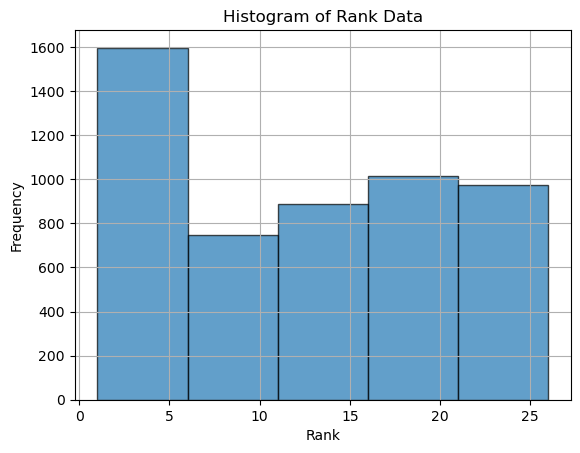

In [60]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual rank column data)
rank_data = [2, 4, 3, 6, 5, 7, 8, 5, 3, 4, 5, 2, 3, 4, 6, 7, 8, 5, 3, 4]

# Create a histogram
plt.hist(temp['SR_RANK'], bins=5, edgecolor='k', alpha=0.7)  # You can adjust the number of bins as needed
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Rank Data')
plt.grid(True)

# Show the histogram
plt.show()





In [61]:

# Define bin edges based on your minimum and maximum ranks
min_rank = 1
max_rank = 26
bin_width = 4 # Adjust the bin width as needed
bin_edges = list(range(min_rank, max_rank + 1, bin_width)) + [max_rank + 1]

# Create a new column 'Bin' to store bin labels
temp['Bin'] = pd.cut(temp['SR_RANK'], bins=bin_edges, labels=[f'{i}-{i+bin_width-1}' for i in bin_edges[:-1]], right=False)






In [62]:

# Create a DataFrame
df = pd.DataFrame(temp)

# Create separate DataFrames for each bin
bin_dataframes = {}
for bin_label in df['Bin'].unique():
    bin_dataframes[bin_label] = df[df['Bin'] == bin_label].copy()

In [63]:
bin_dataframes = {}
for i, bin_label in enumerate(df['Bin'].unique(), start=1):
    bin_dataframes[f'df{i}'] = df[df['Bin'] == bin_label].copy()

# Assign the separate DataFrames to df1, df2, df3, etc.
df1 = bin_dataframes['df1']
df2 = bin_dataframes['df2']
df3 = bin_dataframes['df3']
df4 = bin_dataframes['df4']
df5 = bin_dataframes['df5']
df6 = bin_dataframes['df6']
df7 = bin_dataframes['df7']


In [71]:
df7.head(2)


,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_4_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Bin
17,1.250,29,360,0,1,0,5106.700,4069,0,0,...,19028,35541,65613,0,2.000,5.000,1,0,13,13-16
20,1.500,36,92,0,1,0,4692.950,3190,1,0,...,16760,25800,52673,0,4.000,4.000,1,0,13,13-16


In [107]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)
print(df7.shape)


(1403, 26)
(840, 26)
(625, 26)
(750, 26)
(225, 26)
(628, 26)
(748, 26)


In [26]:
df2.head()

NameError: name 'df2' is not defined

In [108]:
df5.drop("Bin",axis =1,inplace =True )
df4.drop("Bin",axis =1,inplace =True )
df3.drop("Bin",axis =1,inplace =True )
df2.drop("Bin",axis =1,inplace =True )
df1.drop("Bin",axis =1,inplace =True )
df6.drop("Bin",axis =1,inplace =True )
df7.drop("Bin",axis =1,inplace =True )

In [109]:
df5.to_csv('df5.csv', index=False)
df4.to_csv('df4.csv', index=False)
df3.to_csv('df3.csv', index=False)
df2.to_csv('df2.csv', index=False)
df1.to_csv('df1.csv', index=False)
df6.to_csv('df6.csv', index=False)
df7.to_csv('df7.csv', index=False)

In [159]:
temp.head()

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_2_WEEK_SALES,LAST_4_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK
23063,1.990,33,244,0,1,0,7732.070,3878,0,0,...,11940,19585,33053,56262,0,3.000,2.700,1,0,2
12293,0.990,26,182,0,1,0,1148.400,1160,1,1,...,3778,6026,10334,23683,0,6.000,3.800,1,0,19
17084,3.500,26,565,0,1,0,24469.500,8152,0,0,...,22935,30222,41912,71138,1,5.000,4.200,1,0,10
25142,1.000,35,342,0,1,0,2342.000,2342,0,0,...,6341,10458,15488,15495,0,1.000,1.000,1,0,1
8504,1.250,44,87,0,4,0,887.500,710,1,0,...,2122,3507,6064,9511,0,1.000,5.000,1,0,21


In [387]:
def custom_round(value):
    decimal_part = value - int(value)
    if decimal_part < 0.5:
        return int(value)
    else:
        return int(value) + 1

In [220]:
temp1 = temp.sample(1)

In [202]:
# Load the model from the file
gbm = joblib.load('lgb_model.pkl')

In [221]:
temp1.head()

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_2_WEEK_SALES,LAST_4_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK
6545,1.990,36,308,0,1,0,13222.000,6632,1,1,...,22562,38807,73700,123033,0,2.000,4.000,1,0,17


In [483]:
selected_rows = temp[temp["SR_RANK"]==26].head(6)

In [485]:
import shap
import numpy as np
import pandas as pd
import lightgbm as lgb
from multiprocessing import Pool

# Load your model and DataFrame here
# gbm = load_model()
# temp = load_dataframe()
def optimizer(data, original_data, model):
    
    # Define the continuous variables and their allowed ranges
    continuous_variables = {
        'COMP_TITLE_LENGTH': (20, 60),
        'COMP_DESCRIPTION_LENGTH': (90, 550),
        'COMP_VIDEO_COUNT': (0.0, 1.0),
        'COMP_IMG_COUNT': (1, 5),
        'SEARCH_TERM_COUNT_IN_NAME': (0, 1),
        'SEARCH_TERM_COUNT_IN_DESC': (0, 10),
        'SEARCH_TERM_FW_POS_IN_TITLE': (0, 7),
        'Retailer_Margin': (1, 3),
        'FB_FEEDBACK_AVG_RATING': (2, 4),
        'FB_FEEDBACK_COMMENT_COUNT': (1, 70)
        # Add other continuous variables here
    }

    # Define possible values for categorical features
    categorical_features = {
        'COMP_HAS_RICH_CONTENT': [0, 1],
        'SEARCH_TERM_IN_NAME': [0, 1],
        'SEARCH_TERM_IN_DESC': [0, 1],
        'HOLIDAY_FLAG': [0, 1],
        'AV_OOS_AVAILABLE': [0, 1],
        'AV_OOS_OOS': [0, 1]
        # Add other categorical features and their possible values here
    }

    # Specify the non-categorical columns explicitly
    non_categorical_columns = [col for col in data.columns if #####################
                               col not in continuous_variables.keys() and col not in categorical_features.keys() and
                               col != 'SR_RANK']

    # Define the learning rate for gradient descent
    learning_rate = 0.01

    # Define the maximum number of iterations for gradient descent
    max_iterations = 50

    # Define the tolerance for improvement in SR_RANK
    tolerance = 0.1

    # Initialize a new DataFrame to store optimized results
    optimized_data = pd.DataFrame(columns=data.columns)#######################
    
    

    # Start the optimization loop for each row
    for idx, row in data.iterrows():  
      
        instance = pd.DataFrame(row).transpose()
        
        # Initial SR_RANK value
        initial_sr_rank = instance['SR_RANK'].values[0]
       
       
        

        # Calculate SHAP values for the initial instance
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(instance.drop(['SR_RANK'], axis=1))

        # Initial SR_RANK value
        #nitial_sr_rank = instance['SR_RANK'].values[0]

        # Start the optimization loop for this instance
        for iteration in range(max_iterations):
            # Calculate the feature importances based on SHAP values for one-hot encoded columns
            abs_shap_values = np.abs(shap_values)
            sum_abs_shap_values = np.sum(abs_shap_values, axis=1)
            rel_importance = np.sum(abs_shap_values, axis=0) / np.sum(sum_abs_shap_values)

            # Copy the instance for modification
            new_instance = instance.copy()

            # Update continuous variables within their allowed ranges
            for var, (min_val, max_val) in continuous_variables.items():
                change = learning_rate * shap_values[0][list(instance.columns).index(var)]
                new_value = new_instance[var] + change

                # Ensure the new value is within the specified range using np.clip
                new_value = np.clip(new_value, min_val, max_val)
                new_instance[var] = new_value

            # Update categorical features
            for cat_var, cat_values in categorical_features.items():
                change = learning_rate * shap_values[0][list(instance.columns).index(cat_var)]
                current_value = new_instance[cat_var]

                # Convert categorical feature values to lists
                cat_values_list = list(cat_values)

                # Calculate the index of the new value based on SHAP importance
                current_index = cat_values_list.index(current_value.item())
                new_index = max(0, min(len(cat_values_list) - 1, current_index + int(round(change))))

                # Set the new value based on the calculated index
                new_instance[cat_var] = cat_values_list[new_index]

            # Predict SR_RANK with the updated instance
            new_sr_rank = model.predict(new_instance.drop(['SR_RANK'], axis=1))[0]

            # Check if the SR_RANK has improved within the tolerance
            if abs(new_sr_rank - initial_sr_rank) < tolerance:
                break

            # Update the instance for the next iteration
            if initial_sr_rank < new_sr_rank:
                new_sr_rank = initial_sr_rank
                
            # Ensure that SR_RANK does not go below 1
            new_sr_rank = max(new_sr_rank, 1)

            new_instance['SR_RANK'] = new_sr_rank

        # Append the optimized instance to the new DataFrame
        new_instance.index = [idx]  # Set the index to match the original row
        optimized_data = optimized_data.append(new_instance, ignore_index=True)
        
        
  
    # Apply the custom rounding function to the 'rank' column using .loc and .apply
    optimized_data.loc[:, 'SR_RANK'] = optimized_data['SR_RANK'].apply(custom_round)  
    
    # Add the 'Index' column back to the optimized_data and test_data
    optimized_data['Index'] =  data.index
    
    data['Index'] = data.index
    
   
    
    # Extract the 'GTIN' column from the original data
    gtin_column = original_data[['Index', 'GTIN']]

    # Merge the 'optimized_data' with the 'GTIN' column from 'original_data' based on 'Index'
    after = optimized_data.merge(gtin_column, on='Index')
    
    before = data.merge(gtin_column, on='Index')
    
    
    after['data_status'] = "optimized_data"
    
    before['data_status'] = "test_data"
    
    
    result = pd.concat([before, after], axis = 0)
    
    
    
        
    # The 'optimized_data' DataFrame now contains the optimized values for all rows
    # Save df1 to a CSV file
    #optimized_data.to_csv('Bin_26.csv', index=False)
    
    return result






In [486]:
result_data = optimizer(selected_rows,original_data, gbm)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [487]:
result_data  ##0.01

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,2.250,47.000,124.000,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.000,3.200,1,0,26,14545,GTIN31,test_data
1,1.350,27.000,186.000,0.000,1.000,0,3252.150,2406.000,0,0,...,32225.000,0,4.000,4.000,1,0,26,6552,GTIN11,test_data
2,1.650,49.000,96.000,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.000,4.500,1,0,26,19209,GTIN44,test_data
3,1.800,30.000,246.000,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.000,5.000,1,0,26,2561,GTIN4,test_data
4,1.250,24.000,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.800,1,0,26,8710,GTIN15,test_data
5,0.990,26.000,182.000,0.000,1.000,0,1167.210,1179.000,1,1,...,20627.000,0,7.000,4.000,1,0,26,12451,GTIN20,test_data
0,2.250,46.991,124.011,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.005,3.205,1,0,15,14545,GTIN31,optimized_data
1,1.350,27.006,186.008,0.000,1.001,0,3252.150,2406.000,0,0,...,32225.000,0,4.005,3.997,1,0,15,6552,GTIN11,optimized_data
2,1.650,48.992,96.007,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.019,4.000,1,0,16,19209,GTIN44,optimized_data
3,1.800,30.000,245.997,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.009,4.000,1,0,18,2561,GTIN4,optimized_data


In [482]:
result_data  ##4

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,2.250,47.000,124.000,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.000,3.200,1,0,26,14545,GTIN31,test_data
1,1.350,27.000,186.000,0.000,1.000,0,3252.150,2406.000,0,0,...,32225.000,0,4.000,4.000,1,0,26,6552,GTIN11,test_data
2,1.650,49.000,96.000,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.000,4.500,1,0,26,19209,GTIN44,test_data
3,1.800,30.000,246.000,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.000,5.000,1,0,26,2561,GTIN4,test_data
4,1.250,24.000,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.800,1,0,26,8710,GTIN15,test_data
5,0.990,26.000,182.000,0.000,1.000,0,1167.210,1179.000,1,1,...,20627.000,0,7.000,4.000,1,0,26,12451,GTIN20,test_data
0,2.250,43.248,128.466,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,6.062,4.000,1,0,13,14545,GTIN31,optimized_data
1,1.350,29.516,189.240,0.000,1.402,0,3252.150,2406.000,0,1,...,32225.000,0,6.006,2.626,1,0,9,6552,GTIN11,optimized_data
2,1.650,45.661,98.670,0.000,1.000,0,8683.000,5262.000,0,0,...,89176.000,0,15.409,4.000,1,0,15,19209,GTIN44,optimized_data
3,1.800,30.036,244.771,0.000,1.122,0,4772.180,2651.000,1,1,...,116430.000,0,6.545,4.000,1,0,21,2561,GTIN4,optimized_data


In [470]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.500,18.000,458.000,0.000,1.000,0,20724.400,13812.000,0,0,...,400440.000,0,4.000,3.000,1,0,15,16360,GTIN38,test_data
1,3.000,24.000,109.000,0.000,1.000,0,4235.300,1582.000,0,0,...,41553.000,0,71.000,4.700,1,0,15,3256,GTIN5,test_data
2,2.250,47.000,88.000,0.000,1.000,0,6511.500,2894.000,0,0,...,43153.000,1,4.000,3.200,1,0,15,14627,GTIN31,test_data
3,3.500,26.000,247.000,0.000,1.000,0,28254.160,8072.000,1,1,...,75242.000,0,4.000,4.000,1,0,15,17139,GTIN39,test_data
4,1.500,44.000,476.000,0.000,1.000,0,1027.500,685.000,1,1,...,19203.000,1,9.000,4.800,1,0,15,8525,GTIN13,test_data
5,1.250,25.000,110.000,0.000,1.000,0,10613.250,8486.000,0,0,...,129243.000,0,1.000,1.000,1,0,15,382,GTIN2,test_data
6,1.500,38.000,368.000,0.000,1.000,0,3738.200,2492.000,1,1,...,202506.000,1,7.000,4.800,1,0,15,9648,GTIN15,test_data
7,3.000,24.000,109.000,0.000,1.000,0,10892.000,5442.000,0,0,...,105760.000,0,71.000,4.700,1,0,15,3229,GTIN5,test_data
8,1.250,22.000,199.000,0.000,1.000,0,17919.200,14332.000,0,0,...,351696.000,0,4.000,4.000,1,0,15,10569,GTIN17,test_data
9,3.500,26.000,247.000,0.000,1.000,0,12684.500,4226.000,1,1,...,96663.000,0,4.000,4.000,1,0,15,17605,GTIN39,test_data


In [466]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.500,18.000,458.000,0.000,1.000,0,20724.400,13812.000,0,0,...,400440.000,0,4.000,3.000,1,0,15,16360,GTIN38,test_data
1,3.000,24.000,109.000,0.000,1.000,0,4235.300,1582.000,0,0,...,41553.000,0,71.000,4.700,1,0,15,3256,GTIN5,test_data
2,2.250,47.000,88.000,0.000,1.000,0,6511.500,2894.000,0,0,...,43153.000,1,4.000,3.200,1,0,15,14627,GTIN31,test_data
3,3.500,26.000,247.000,0.000,1.000,0,28254.160,8072.000,1,1,...,75242.000,0,4.000,4.000,1,0,15,17139,GTIN39,test_data
4,1.500,44.000,476.000,0.000,1.000,0,1027.500,685.000,1,1,...,19203.000,1,9.000,4.800,1,0,15,8525,GTIN13,test_data
5,1.250,25.000,110.000,0.000,1.000,0,10613.250,8486.000,0,0,...,129243.000,0,1.000,1.000,1,0,15,382,GTIN2,test_data
6,1.500,38.000,368.000,0.000,1.000,0,3738.200,2492.000,1,1,...,202506.000,1,7.000,4.800,1,0,15,9648,GTIN15,test_data
7,3.000,24.000,109.000,0.000,1.000,0,10892.000,5442.000,0,0,...,105760.000,0,71.000,4.700,1,0,15,3229,GTIN5,test_data
8,1.250,22.000,199.000,0.000,1.000,0,17919.200,14332.000,0,0,...,351696.000,0,4.000,4.000,1,0,15,10569,GTIN17,test_data
9,3.500,26.000,247.000,0.000,1.000,0,12684.500,4226.000,1,1,...,96663.000,0,4.000,4.000,1,0,15,17605,GTIN39,test_data


In [447]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,0.990,33.000,571.000,0.000,1.000,0,3140.610,3172.000,1,0,...,51278.000,1,6.000,5.000,1,0,11,9754,GTIN16,test_data
1,2.000,30.000,324.000,0.000,1.000,0,5775.670,2993.000,1,1,...,76287.000,0,6.000,4.300,1,0,11,1668,GTIN4,test_data
2,1.990,36.000,308.000,0.000,1.000,0,15385.000,7711.000,0,0,...,208046.000,1,2.000,4.000,1,0,11,6526,GTIN10,test_data
3,1.250,36.000,182.000,0.000,4.000,0,1987.500,1584.000,0,0,...,30314.000,0,1.000,5.000,1,0,11,4203,GTIN6,test_data
4,1.800,30.000,246.000,0.000,1.000,0,4712.490,2618.000,1,0,...,115906.000,0,3.000,5.000,1,0,11,2583,GTIN4,test_data
5,1.250,42.000,94.000,0.000,1.000,0,8885.000,7088.000,0,0,...,91912.000,1,67.000,4.400,1,0,11,21202,GTIN51,test_data
6,7.000,38.000,286.000,0.000,1.000,0,96.180,27.000,0,0,...,7022.000,0,2.000,3.000,1,0,11,12477,GTIN21,test_data
7,1.350,42.000,94.000,0.000,1.000,0,9166.200,6750.000,0,0,...,127824.000,0,68.000,4.400,1,0,11,21519,GTIN51,test_data
8,1.800,30.000,246.000,0.000,1.000,0,8407.400,5478.000,1,1,...,114135.000,0,4.000,5.000,1,0,11,1644,GTIN4,test_data
9,1.500,18.000,458.000,0.000,1.000,0,8003.400,5334.000,0,0,...,244002.000,1,4.000,3.000,1,0,11,16382,GTIN38,test_data


In [443]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,0.990,33.000,571.000,0.000,1.000,0,3140.610,3172.000,1,0,...,51278.000,1,6.000,5.000,1,0,11,9754,GTIN16,test_data
1,2.000,30.000,324.000,0.000,1.000,0,5775.670,2993.000,1,1,...,76287.000,0,6.000,4.300,1,0,11,1668,GTIN4,test_data
2,1.990,36.000,308.000,0.000,1.000,0,15385.000,7711.000,0,0,...,208046.000,1,2.000,4.000,1,0,11,6526,GTIN10,test_data
3,1.250,36.000,182.000,0.000,4.000,0,1987.500,1584.000,0,0,...,30314.000,0,1.000,5.000,1,0,11,4203,GTIN6,test_data
4,1.800,30.000,246.000,0.000,1.000,0,4712.490,2618.000,1,0,...,115906.000,0,3.000,5.000,1,0,11,2583,GTIN4,test_data
5,1.250,42.000,94.000,0.000,1.000,0,8885.000,7088.000,0,0,...,91912.000,1,67.000,4.400,1,0,11,21202,GTIN51,test_data
6,7.000,38.000,286.000,0.000,1.000,0,96.180,27.000,0,0,...,7022.000,0,2.000,3.000,1,0,11,12477,GTIN21,test_data
7,1.350,42.000,94.000,0.000,1.000,0,9166.200,6750.000,0,0,...,127824.000,0,68.000,4.400,1,0,11,21519,GTIN51,test_data
8,1.800,30.000,246.000,0.000,1.000,0,8407.400,5478.000,1,1,...,114135.000,0,4.000,5.000,1,0,11,1644,GTIN4,test_data
9,1.500,18.000,458.000,0.000,1.000,0,8003.400,5334.000,0,0,...,244002.000,1,4.000,3.000,1,0,11,16382,GTIN38,test_data


In [431]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,3.500,26.000,565.000,0.000,1.000,0,24469.500,8152.000,0,0,...,71138.000,1,5.000,4.200,1,0,10,17084,GTIN39,test_data
1,1.350,27.000,186.000,0.000,1.000,0,4646.200,3326.000,0,0,...,37816.000,0,4.000,4.000,1,0,10,6757,GTIN11,test_data
2,1.250,42.000,94.000,0.000,1.000,0,9998.000,7960.000,0,0,...,118760.000,0,68.000,4.400,1,0,10,21712,GTIN51,test_data
3,3.500,26.000,565.000,0.000,1.000,0,20371.500,6789.000,1,1,...,73936.000,1,5.000,4.200,1,0,10,17530,GTIN39,test_data
4,3.500,28.000,109.000,0.000,1.000,0,42764.500,17101.000,0,0,...,38546.000,1,1.000,3.000,1,0,10,22383,GTIN53,test_data
5,1.250,28.000,101.000,0.000,3.000,0,3276.250,2621.000,0,0,...,38841.000,0,3.000,3.000,1,0,10,13741,GTIN26,test_data
6,1.250,32.000,119.000,0.000,4.000,0,1047.500,838.000,1,0,...,14648.000,0,1.000,1.000,1,0,10,1246,GTIN3,test_data
7,1.250,28.000,101.000,0.000,3.000,0,3152.500,2522.000,0,0,...,39407.000,0,3.000,3.000,1,0,10,13787,GTIN26,test_data
8,3.000,24.000,109.000,0.000,1.000,0,30045.000,14994.000,0,1,...,62823.000,0,71.000,4.700,1,0,10,2676,GTIN5,test_data
9,1.800,30.000,246.000,0.000,1.000,0,17415.810,9675.000,1,1,...,91638.000,1,3.000,5.000,1,0,10,1448,GTIN4,test_data


In [421]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,0.990,30.000,331.000,0.000,1.000,0,1682.120,1692.000,1,0,...,63558.000,0,6.000,4.700,1,0,10,23846,GTIN58,test_data
1,1.250,27.000,203.000,0.000,1.000,0,2858.500,2275.000,0,0,...,34517.000,1,1.000,1.000,1,0,10,7047,GTIN11,test_data
2,1.500,39.000,96.000,0.000,1.000,0,5700.800,3800.000,1,0,...,89114.000,0,7.000,4.400,1,0,10,19172,GTIN44,test_data
3,2.000,48.000,108.000,0.000,5.000,0,1606.000,803.000,1,0,...,25150.000,0,32.000,4.400,1,0,10,14956,GTIN33,test_data
4,3.500,49.000,312.000,0.000,1.000,0,7686.000,2196.000,1,0,...,451581.000,0,9.000,4.900,1,0,10,18594,GTIN41,test_data
0,0.990,30.794,326.244,0.000,1.000,0,1682.120,1692.000,1,0,...,63558.000,0,8.283,4.000,1,0,10,23846,GTIN58,optimized_data
1,1.250,28.720,203.522,0.000,1.363,0,2858.500,2275.000,0,0,...,34517.000,1,2.970,2.000,1,0,10,7047,GTIN11,optimized_data
2,1.500,35.368,98.788,0.000,1.000,0,5700.800,3800.000,0,0,...,89114.000,0,7.700,2.000,1,0,10,19172,GTIN44,optimized_data
3,2.000,44.032,108.363,0.000,5.000,0,1606.000,803.000,1,0,...,25150.000,0,33.766,2.000,1,0,10,14956,GTIN33,optimized_data
4,3.500,45.483,309.860,0.000,1.000,0,7686.000,2196.000,0,0,...,451581.000,0,12.914,4.000,1,0,10,18594,GTIN41,optimized_data


In [417]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.350,36.000,92.000,0.000,1.000,0,4450.700,3218.000,0,0,...,51552.000,1,4.000,4.000,1,0,10,12565,GTIN22,test_data
1,1.500,39.000,96.000,0.000,1.000,0,8546.000,5697.000,1,0,...,88302.000,0,7.000,4.400,1,0,10,19228,GTIN44,test_data
2,1.240,38.000,1066.000,0.000,1.000,0,2639.960,2627.000,1,1,...,38158.000,1,NaN,NaN,1,0,10,24900,GTIN63,test_data
3,1.500,28.000,101.000,0.000,3.000,0,8741.900,5827.000,0,0,...,85708.000,0,3.000,3.000,1,0,10,14023,GTIN26,test_data
4,1.800,30.000,324.000,0.000,1.000,0,7584.710,4524.000,1,1,...,75945.000,0,4.000,5.000,1,0,10,2055,GTIN4,test_data
0,1.350,35.186,94.572,0.000,1.000,0,4450.700,3218.000,0,0,...,51552.000,1,4.334,3.380,1,0,10,12565,GTIN22,optimized_data
1,1.500,38.392,96.868,0.000,1.000,0,8546.000,5697.000,1,0,...,88302.000,0,7.310,3.850,1,0,10,19228,GTIN44,optimized_data
2,1.240,36.806,550.000,0.000,1.000,0,2639.960,2627.000,1,1,...,38158.000,1,NaN,NaN,1,0,10,24900,GTIN63,optimized_data
3,1.500,28.105,101.507,0.000,1.800,0,8741.900,5827.000,0,0,...,85708.000,0,3.294,3.404,1,0,10,14023,GTIN26,optimized_data
4,1.800,29.815,323.330,0.000,1.000,0,7584.710,4524.000,1,1,...,75945.000,0,3.181,4.000,1,0,5,2055,GTIN4,optimized_data


In [413]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.490,31.000,96.000,0.000,3.000,0,0.000,0.000,1,0,...,0.000,0,4.000,4.000,1,0,4,25565,GTIN65,test_data
1,3.500,31.000,98.000,0.000,1.000,0,2306.500,659.000,0,0,...,4603.000,0,1.000,5.000,1,0,4,25546,GTIN65,test_data
2,3.500,32.000,92.000,0.000,1.000,0,7294.000,2084.000,1,0,...,11845.000,0,1.000,5.000,1,0,4,18285,GTIN41,test_data
3,1.490,26.000,109.000,0.000,3.000,0,1016.180,682.000,1,0,...,123529.000,0,1.000,5.000,1,0,4,13698,GTIN25,test_data
4,3.500,49.000,312.000,0.000,1.000,0,9042.500,2583.000,1,0,...,448380.000,0,10.000,4.900,1,0,4,18405,GTIN41,test_data
0,1.490,30.983,96.866,0.000,2.394,0,0.000,0.000,1,0,...,0.000,0,4.206,3.553,1,0,4,25565,GTIN65,optimized_data
1,3.500,31.023,98.243,0.000,1.000,0,2306.500,659.000,0,0,...,4603.000,0,1.000,4.000,1,0,4,25546,GTIN65,optimized_data
2,3.500,31.900,93.037,0.000,1.000,0,7294.000,2084.000,0,0,...,11845.000,0,1.000,4.000,1,0,4,18285,GTIN41,optimized_data
3,1.490,26.185,108.967,0.000,1.265,0,1016.180,682.000,1,0,...,123529.000,0,1.000,4.000,1,0,4,13698,GTIN25,optimized_data
4,3.500,48.154,311.550,0.000,1.000,0,9042.500,2583.000,0,0,...,448380.000,0,9.901,4.000,1,0,4,18405,GTIN41,optimized_data


In [409]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.250,24.000,220.000,0.000,1.000,0,11240.000,8992.000,0,0,...,162362.000,0,6.000,4.800,1,0,26,9483,GTIN15,test_data
1,3.500,49.000,312.000,0.000,1.000,0,7686.000,2196.000,0,0,...,451581.000,0,9.000,4.900,1,0,26,18468,GTIN41,test_data
2,4.000,34.000,274.000,0.000,1.000,0,7988.350,2163.000,1,1,...,114172.000,0,92.000,4.600,1,0,26,19827,GTIN47,test_data
3,4.000,34.000,274.000,0.000,1.000,0,16594.950,4539.000,1,1,...,120133.000,1,92.000,4.600,1,0,26,19659,GTIN47,test_data
4,1.990,33.000,244.000,0.000,1.000,0,19193.240,9608.000,0,0,...,90290.000,1,3.000,2.700,1,0,26,23115,GTIN56,test_data
0,1.250,25.059,219.843,0.000,1.028,0,11240.000,8992.000,0,1,...,162362.000,0,6.090,4.000,1,0,3,9483,GTIN15,optimized_data
1,3.500,47.007,310.837,0.000,1.000,0,7686.000,2196.000,1,0,...,451581.000,0,13.495,4.000,1,0,8,18468,GTIN41,optimized_data
2,4.000,33.691,273.742,0.000,1.373,0,7988.350,2163.000,1,1,...,114172.000,0,70.000,4.000,1,0,19,19827,GTIN47,optimized_data
3,4.000,33.700,273.866,0.000,1.353,0,16594.950,4539.000,1,1,...,120133.000,1,70.000,4.000,1,0,21,19659,GTIN47,optimized_data
4,1.990,32.544,243.909,0.000,1.182,0,19193.240,9608.000,0,0,...,90290.000,1,4.021,4.000,1,0,10,23115,GTIN56,optimized_data


In [405]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,2.500,49.000,199.000,0.000,1.000,0,12349.500,4878.000,1,0,...,77518.000,0,5.000,4.200,1,0,26,21973,GTIN52,test_data
1,2.250,47.000,124.000,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.000,3.200,1,0,26,14545,GTIN31,test_data
2,1.250,44.000,87.000,0.000,4.000,0,1042.500,834.000,1,0,...,12088.000,0,1.000,5.000,1,0,26,8478,GTIN13,test_data
3,2.000,30.000,324.000,0.000,1.000,0,4928.350,2464.000,1,1,...,63203.000,1,6.000,4.300,1,0,26,2346,GTIN4,test_data
4,0.990,33.000,156.000,0.000,1.000,0,1675.080,1692.000,1,1,...,80092.000,0,6.000,5.000,1,0,26,9976,GTIN16,test_data
0,2.500,48.159,199.966,0.000,1.000,0,12349.500,4878.000,1,1,...,77518.000,0,5.931,4.000,1,0,11,21973,GTIN52,optimized_data
1,2.250,46.062,125.117,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.515,3.714,1,0,14,14545,GTIN31,optimized_data
2,1.250,43.480,90.000,0.000,5.000,0,1042.500,834.000,1,0,...,12088.000,0,1.714,4.000,1,0,18,8478,GTIN13,optimized_data
3,2.000,30.125,323.773,0.000,1.000,0,4928.350,2464.000,1,1,...,63203.000,1,6.685,4.000,1,0,20,2346,GTIN4,optimized_data
4,0.990,32.867,156.328,0.000,1.000,0,1675.080,1692.000,1,1,...,80092.000,0,6.846,4.000,1,0,12,9976,GTIN16,optimized_data


In [401]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,4.000,34.000,274.000,0.000,1.000,0,16594.950,4539.000,1,1,...,120133.000,1,92.000,4.600,1,0,26,19659,GTIN47,test_data
1,1.350,27.000,186.000,0.000,1.000,0,3252.150,2406.000,0,0,...,32225.000,0,4.000,4.000,1,0,26,6756,GTIN11,test_data
2,1.250,18.000,441.000,0.000,1.000,0,9877.800,7322.000,0,0,...,523526.000,0,4.000,3.000,1,0,26,16070,GTIN38,test_data
3,1.350,36.000,180.000,0.000,1.000,0,4596.150,3391.000,0,0,...,37444.000,0,3.000,5.000,1,0,26,3974,GTIN6,test_data
4,1.250,44.000,87.000,0.000,4.000,0,827.500,662.000,1,0,...,8036.000,0,1.000,5.000,1,0,26,8610,GTIN13,test_data
0,4.000,33.985,273.993,0.000,1.018,0,16594.950,4539.000,1,1,...,120133.000,1,70.000,4.000,1,0,16,19659,GTIN47,optimized_data
1,1.350,27.063,186.081,0.000,1.010,0,3252.150,2406.000,0,0,...,32225.000,0,4.050,3.966,1,0,15,6756,GTIN11,optimized_data
2,1.250,20.000,440.926,0.000,1.010,0,9877.800,7322.000,0,0,...,523526.000,0,4.022,3.029,1,0,14,16070,GTIN38,optimized_data
3,1.350,35.963,180.046,0.000,1.001,0,4596.150,3391.000,0,0,...,37444.000,0,3.044,4.000,1,0,14,3974,GTIN6,optimized_data
4,1.250,43.946,90.000,0.000,4.296,0,827.500,662.000,1,0,...,8036.000,0,1.058,4.000,1,0,20,8610,GTIN13,optimized_data


In [396]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,0.990,26.000,182.000,0.000,1.000,0,1341.450,1355.000,1,1,...,71515.000,0,6.000,3.800,1,0,26,11972,GTIN20,test_data
1,1.500,25.000,560.000,0.000,1.000,0,2913.700,1931.000,0,0,...,119917.000,1,5.000,3.400,1,0,26,875,GTIN2,test_data
2,0.990,26.000,182.000,0.000,1.000,0,1167.210,1179.000,1,1,...,20627.000,0,7.000,4.000,1,0,26,12451,GTIN20,test_data
3,1.250,23.000,92.000,0.000,1.000,0,2526.500,2013.000,0,0,...,36851.000,0,3.000,3.700,1,0,26,12829,GTIN22,test_data
4,2.250,47.000,88.000,0.000,1.000,0,6511.500,2894.000,0,0,...,43153.000,1,4.000,3.200,1,0,26,14612,GTIN31,test_data
0,0.990,26.006,182.007,0.000,1.001,0,1341.450,1355.000,1,1,...,71515.000,0,6.007,3.796,1,0,18,11972,GTIN20,optimized_data
1,1.500,25.019,550.000,0.000,1.002,0,2913.700,1931.000,0,0,...,119917.000,1,5.007,3.416,1,0,21,875,GTIN2,optimized_data
2,0.990,26.007,182.004,0.000,1.001,0,1167.210,1179.000,1,1,...,20627.000,0,7.004,3.998,1,0,10,12451,GTIN20,optimized_data
3,1.250,23.020,92.034,0.000,1.000,0,2526.500,2013.000,0,0,...,36851.000,0,3.003,3.696,1,0,20,12829,GTIN22,optimized_data
4,2.250,46.988,90.000,0.000,1.000,0,6511.500,2894.000,0,0,...,43153.000,1,4.003,3.202,1,0,15,14612,GTIN31,optimized_data


In [392]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.250,44.000,87.000,0.000,4.000,0,986.250,789.000,1,0,...,12201.000,0,1.000,5.000,1,0,26,8510,GTIN13,test_data
1,1.750,53.000,197.000,0.000,1.000,0,1246.000,712.000,1,1,...,2552.000,0,1.000,1.000,1,0,26,18839,GTIN42,test_data
2,0.990,35.000,342.000,0.000,1.000,0,3289.880,3308.000,0,0,...,48272.000,0,6.000,4.200,1,0,26,24957,GTIN64,test_data
3,0.990,35.000,342.000,0.000,1.000,0,3289.880,3308.000,0,0,...,48272.000,0,6.000,4.200,1,0,26,25248,GTIN64,test_data
4,1.250,24.000,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.800,1,0,26,8710,GTIN15,test_data
0,1.250,41.756,96.152,0.000,5.000,0,986.250,789.000,1,0,...,12201.000,0,3.722,4.000,1,0,16,8510,GTIN13,optimized_data
1,1.750,45.397,198.116,0.000,1.000,0,1246.000,712.000,1,1,...,2552.000,0,1.000,3.751,1,0,11,18839,GTIN42,optimized_data
2,0.990,27.322,334.574,0.000,1.000,0,3289.880,3308.000,0,0,...,48272.000,0,6.625,2.000,1,0,3,24957,GTIN64,optimized_data
3,0.990,27.322,334.574,0.000,1.000,0,3289.880,3308.000,0,0,...,48272.000,0,6.625,2.000,1,0,3,25248,GTIN64,optimized_data
4,1.250,26.085,219.816,0.000,1.026,0,12278.750,9823.000,0,1,...,240074.000,0,6.093,4.000,1,0,2,8710,GTIN15,optimized_data


In [378]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,2.250,47.000,124.000,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.000,3.200,1,0,26.000,14545,GTIN31,test_data
1,1.350,27.000,186.000,0.000,1.000,0,3252.150,2406.000,0,0,...,32225.000,0,4.000,4.000,1,0,26.000,6552,GTIN11,test_data
2,1.650,49.000,96.000,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.000,4.500,1,0,26.000,19209,GTIN44,test_data
3,1.800,30.000,246.000,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.000,5.000,1,0,26.000,2561,GTIN4,test_data
4,1.250,24.000,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.800,1,0,26.000,8710,GTIN15,test_data
0,2.250,46.999,124.001,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.001,3.201,1,0,15.094,14545,GTIN31,optimized_data
1,1.350,27.001,186.001,0.000,1.000,0,3252.150,2406.000,0,0,...,32225.000,0,4.001,4.000,1,0,14.833,6552,GTIN11,optimized_data
2,1.650,48.999,96.001,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.002,4.000,1,0,16.120,19209,GTIN44,optimized_data
3,1.800,30.000,246.000,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.001,4.000,1,0,18.401,2561,GTIN4,optimized_data
4,1.250,24.001,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.000,1,0,3.798,8710,GTIN15,optimized_data


In [373]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,2.250,47.000,124.000,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.000,3.200,1,0,26.000,14545,GTIN31,test_data
1,1.350,27.000,186.000,0.000,1.000,0,3252.150,2406.000,0,0,...,32225.000,0,4.000,4.000,1,0,26.000,6552,GTIN11,test_data
2,1.650,49.000,96.000,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.000,4.500,1,0,26.000,19209,GTIN44,test_data
3,1.800,30.000,246.000,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.000,5.000,1,0,26.000,2561,GTIN4,test_data
4,1.250,24.000,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.800,1,0,26.000,8710,GTIN15,test_data
0,2.250,46.991,124.011,0.000,1.000,0,11722.500,5210.000,0,0,...,48424.000,1,4.005,3.205,1,0,15.094,14545,GTIN31,optimized_data
1,1.350,27.006,186.008,0.000,1.001,0,3252.150,2406.000,0,0,...,32225.000,0,4.005,3.997,1,0,14.833,6552,GTIN11,optimized_data
2,1.650,48.992,96.007,0.000,1.000,0,8683.000,5262.000,1,0,...,89176.000,0,8.019,4.000,1,0,16.120,19209,GTIN44,optimized_data
3,1.800,30.000,245.997,0.000,1.000,0,4772.180,2651.000,1,1,...,116430.000,0,3.009,4.000,1,0,18.401,2561,GTIN4,optimized_data
4,1.250,24.005,220.000,0.000,1.000,0,12278.750,9823.000,0,0,...,240074.000,0,6.000,4.000,1,0,3.798,8710,GTIN15,optimized_data


In [353]:
result_data

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN,data_status
0,1.990,33.000,244.000,0.000,1.000,0,7732.070,3878.000,0,0,...,56262.000,0,3.000,2.700,1,0,2.000,23063,GTIN56,test_data
1,3.500,26.000,247.000,0.000,1.000,0,12452.500,4150.000,0,0,...,64255.000,0,4.000,4.000,1,0,2.000,17828,GTIN39,test_data
2,1.250,18.000,441.000,0.000,1.000,0,35224.500,28174.000,0,0,...,346406.000,0,4.000,3.000,1,0,12.000,16270,GTIN38,test_data
3,1.250,33.000,95.000,0.000,1.000,0,1750.250,1390.000,0,0,...,17881.000,0,1.000,5.000,1,0,9.000,15498,GTIN36,test_data
4,1.500,44.000,476.000,0.000,1.000,0,1027.500,685.000,1,1,...,19203.000,1,9.000,4.800,1,0,15.000,8525,GTIN13,test_data
0,1.990,31.491,243.288,0.000,1.000,0,7732.070,3878.000,0,1,...,56262.000,0,3.449,2.000,1,0,-0.745,23063,GTIN56,optimized_data
1,3.500,26.539,241.170,0.000,1.000,0,12452.500,4150.000,0,0,...,64255.000,0,3.153,2.000,1,0,2.000,17828,GTIN39,optimized_data
2,1.250,23.930,437.094,0.000,1.495,0,35224.500,28174.000,0,0,...,346406.000,0,4.473,3.922,1,0,3.677,16270,GTIN38,optimized_data
3,1.250,31.929,105.842,0.000,1.000,0,1750.250,1390.000,0,0,...,17881.000,0,1.000,4.000,1,0,6.930,15498,GTIN36,optimized_data
4,1.500,39.401,472.719,0.000,1.419,0,1027.500,685.000,1,1,...,19203.000,1,12.718,4.000,1,0,3.422,8525,GTIN13,optimized_data


In [219]:
result_data2

,SR_PARSED_PRICE,COMP_TITLE_LENGTH,COMP_DESCRIPTION_LENGTH,COMP_VIDEO_COUNT,COMP_IMG_COUNT,COMP_HAS_RICH_CONTENT,RETAIL_SALES_VALUE,RETAIL_SALES_UNIT,SEARCH_TERM_IN_NAME,SEARCH_TERM_IN_DESC,...,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES,HOLIDAY_FLAG,FB_FEEDBACK_COMMENT_COUNT,FB_FEEDBACK_AVG_RATING,AV_OOS_AVAILABLE,AV_OOS_OOS,SR_RANK,Index,GTIN
0,3.500,23,289,0,4,0,18755.000,6249,0,0,...,96404,118993,0,92.000,4.600,1,0,2,19637,GTIN47


In [0]:
## for single value checks

import shap
import numpy as np
import pandas as pd
import lightgbm as lgb


# Select an initial instance (row) from the dataframe

instance = temp.iloc[[5]]

# Calculate SHAP values for the initial instance (outside the loop)
explainer = shap.Explainer(gbm)
shap_values = explainer.shap_values(instance.drop(['SR_RANK'], axis=1))

# Define the continuous variables and their allowed ranges
continuous_variables = {

    'COMP_TITLE_LENGTH': (20, 60),
    'COMP_DESCRIPTION_LENGTH': (90, 550),
    'COMP_VIDEO_COUNT': (0.0, 1.0),
    'COMP_IMG_COUNT' : (1,5),
    'SEARCH_TERM_COUNT_IN_NAME' : (0,1),
    'SEARCH_TERM_COUNT_IN_DESC' : (0,10) ,
    'SEARCH_TERM_FW_POS_IN_TITLE' : (0,7) ,
    'Retailer_Margin' : (1,3),
    'FB_FEEDBACK_AVG_RATING' : (2,4),
    'FB_FEEDBACK_COMMENT_COUNT': (1,70),
    'RETAIL_SALES_VALUE' : (1300,30000),
    'RETAIL_SALES_UNIT':(500,20000)
    # Add other continuous variables here
}

# Define possible values for categorical features
categorical_features = {
        'COMP_HAS_RICH_CONTENT':[0,1],
    'SEARCH_TERM_IN_NAME': [0,1],
    'SEARCH_TERM_IN_DESC': [0,1], 
    'HOLIDAY_FLAG':[0,1], 
    'AV_OOS_AVAILABLE':[0,1], 
    'AV_OOS_OOS':[0,1]
    # Add other categorical features and their possible values here
}


# Specify the non-categorical columns explicitly
non_categorical_columns = [col for col in instance.columns if col not in continuous_variables.keys() and col not in categorical_features.keys() and col != 'SR_RANK']

# Define the learning rate for gradient descent
learning_rate = 4

# Define the maximum number of iterations for gradient descent
max_iterations = 100

# Define the tolerance for improvement in SR_RANK
tolerance = 0.1

# Initial SR_RANK value
initial_sr_rank = instance['SR_RANK'].values[0]

# Start the optimization loop
for iteration in range(max_iterations):
    # Calculate the feature importances based on SHAP values for one-hot encoded columns
    abs_shap_values = np.abs(shap_values)
    sum_abs_shap_values = np.sum(abs_shap_values, axis=1)
    rel_importance = np.sum(abs_shap_values, axis=0) / np.sum(sum_abs_shap_values)
    
    # Copy the instance for modification
    new_instance = instance.copy()
    
    # Update continuous variables within their allowed ranges
    for var, (min_val, max_val) in continuous_variables.items():
        change = learning_rate * shap_values[0][list(instance.columns).index(var)]
        new_value = new_instance[var] + change
        
        # Ensure the new value is within the specified range using np.clip
        new_instance[var] = np.clip(new_value, min_val, max_val)
    
    # Update categorical features
    for cat_var, cat_values in categorical_features.items():
        change = learning_rate * shap_values[0][list(instance.columns).index(cat_var)]
        current_value = new_instance[cat_var]
        
        # Convert categorical feature values to lists
        cat_values_list = list(cat_values)
        
        # Calculate the index of the new value based on SHAP importance
        current_index = cat_values_list.index(current_value.item())
        new_index = max(0, min(len(cat_values_list) - 1, current_index + int(round(change))))
        
        # Set the new value based on the calculated index
        new_instance[cat_var] = cat_values_list[new_index]

    # Predict SR_RANK with the updated instance
    new_sr_rank = gbm.predict(new_instance.drop(['SR_RANK'], axis=1))[0]

    # Check if the SR_RANK has improved within the tolerance
    if abs(new_sr_rank - initial_sr_rank) < tolerance:
        break

    # Update the instance for the next iteration
    if initial_sr_rank < new_sr_rank:
      new_sr_rank=initial_sr_rank
    
    new_instance['SR_RANK'] = new_sr_rank

# The 'instance' variable now contains the optimized values for all features that result in an improved SR_RANK
print("Best rank possible:")
print(new_sr_rank)


In [0]:
instance

In [0]:
new_instance

In [0]:
ff

In [0]:


# # Define the search space for categorical variables
# categorical_space = {
    
#     'COMP_HAS_RICH_CONTENT':[0,1],
#     'SEARCH_TERM_IN_NAME': [0,1],
#     'SEARCH_TERM_IN_DESC': [0,1], 
#     'HOLIDAY_FLAG':[0,1], 
#     'AV_OOS_AVAILABLE':[0,1], 
#     'AV_OOS_OOS':[0,11]
#  }

# # Define the search space for continuous variables
# continuous_space = {
#     'COMP_TITLE_LENGTH': (14, 62),
#     'COMP_DESCRIPTION_LENGTH': (26, 1066),
#     'COMP_VIDEO_COUNT': (0.0, 100.0),
#     'COMP_IMG_COUNT' : (),
#     'SEARCH_TERM_COUNT_IN_NAME' : (),
#      'SEARCH_TERM_COUNT_IN_DESC' : () ,
#      'SEARCH_TERM_FW_POS_IN_TITLE' : () ,
#      'Retailer_Margin' : (),


# }

# # Define the search space for non-control variables
# non_control_space = {
#     'SR_PARSED_PRICE': (0.8, 7),
#     'RETAIL_SALES_VALUE': (0, 1000),
#     'RETAIL_SALES_UNIT' : () ,
#     'LAST_1_WEEK_SALES' : (),
#     'LAST_2_WEEK_SALES' : (),
#     'LAST_4_WEEK_SALES' : (),
#     'LAST_8_WEEK_SALES' : (),
#     'LAST_16_WEEK_SALES' : (),
#     'FB_FEEDBACK_COMMENT_COUNT' : () ,
    
# }



In [0]:
import shap
import numpy as np
import pandas as pd
import lightgbm as lgb

import shap
# Select an initial instance (row) from the dataframe
instance = temp.iloc[[106]]
ins= temp.iloc[106]


# Set the initial value of the target feature to the current value
target_feature_initial_value = instance['SR_RANK'].values[0]

# Define the desired target value for the target feature
desired_target_value = 1

# Set the tolerance for the difference between the predicted value and the desired target value
tolerance = 1e-6

# Define the learning rate for gradient descent
learning_rate = 10

# Define the maximum number of iterations for gradient descent
max_iterations = 1000



# Calculate SHAP values for the initial instance (outside the loop)
explainer = shap.Explainer(gbm)
shap_values = explainer.shap_values(instance.drop(['SR_RANK'], axis=1))

# Specify the one-hot encoded columns explicitly
one_hot_columns = ['AV_OOS_AVAILABLE', 'AV_OOS_OOS', 'PACK_TYPE_Boxed Chocolate',
       'PACK_TYPE_Multipack', 'PACK_TYPE_Packaged',
       'PACK_TYPE_Premium Selection', 'PACK_TYPE_Single','PR_SUBSCRIPTION_NOT AVAILABLE']

# Loop until the predicted value of the target feature is within the tolerance of the desired target value
for i in range(max_iterations):
    # Calculate the feature weightages for the current instance based on SHAP values
    abs_shap_values = np.abs(shap_values)
    sum_abs_shap_values = np.sum(abs_shap_values, axis=1)
    rel_importance = np.sum(abs_shap_values, axis=0) / np.sum(sum_abs_shap_values)

    # Create a new instance with the same column structure as the original dataframe
    new_instance = instance.copy()
    new_instance['SR_RANK']=desired_target_value

    for col in one_hot_columns:
        new_instance[col] += round(learning_rate * (rel_importance[one_hot_columns.index(col)]))
    


    # Recalculate the predicted value of the target feature
    predicted_target_value = gbm.predict(new_instance.drop(['SR_RANK'], axis=1))

    # Calculate the desired change in the target feature value
    desired_change = (target_feature_initial_value - desired_target_value)
    # print(desired_change)

    # Apply gradient descent to update other columns
    non_categorical_columns = [col for col in instance.columns if col not in one_hot_columns + ['SR_RANK']]
    for col in non_categorical_columns:
        new_instance[col] += round(learning_rate * (rel_importance[non_categorical_columns.index(col)] * desired_change))

    # Check if the predicted value is within the tolerance of the desired target value
    if abs(predicted_target_value - desired_target_value) < tolerance:
        break

# The 'new_instance' variable now contains the values for all features that produce the desired target value
print("Final Instance:")
print(new_instance)


In [0]:
instance

In [0]:
new_instance

In [0]:
temp.head(1)

In [0]:
ff

In [0]:
import lightgbm as lgb
import pandas as pd
import numpy as np

# Load your dataset and model here
# X, y = load_data()  # Load your dataset
# gbm = load_model()  # Load your trained LightGBM model

# Input feature names
feature_names = model_x_train.columns

# Function to predict with the current feature values
def predict_with_features(feature_values):
    # Create a DataFrame with the provided feature values
    input_data = pd.DataFrame([feature_values], columns=feature_names)
    
    # Predict with the model
    prediction = gbm.predict(input_data)[0]
    return prediction

# Initialize feature values
current_feature_values = model_x_train.iloc[0]

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Original_Prediction', 'Changed_Prediction', 'Difference'])

# Loop through each feature and observe its impact
for i, feature_name in enumerate(feature_names):
    # Copy the current feature values to avoid modifying the original
    modified_feature_values = current_feature_values.copy()
    
    # Change the feature value for this iteration (e.g., increment by 1)
    modified_feature_values[i] *= 1.1
    
    # Predict with the original feature values
    original_prediction = predict_with_features(current_feature_values)
    
    # Predict with the changed feature values
    changed_prediction = predict_with_features(modified_feature_values)
    
    # Calculate the difference
    difference = changed_prediction - original_prediction
    
    # Store the results in the DataFrame
    results_df = results_df.append({'Feature': feature_name, 
                                    'Original_Prediction': original_prediction, 
                                    'Changed_Prediction': changed_prediction, 
                                    'Difference': difference}, 
                                   ignore_index=True)


In [0]:
results_df

In [0]:
ff

Simulations

In [0]:
config= {
    # "PREDICTIONS_FILEPATH": "/dbfs/mnt/PROCESS/EU_MW_DCOM/MODEL_OUTPUT/RETAILER_SEARCH_ALGORITHM/ITERATIONS/NLD/MARS/GBM_22032023_1217/GBM_model_python_1679465843553_9_Predictions.csv",
    # "MODEL_FILEPATH": "/dbfs/mnt/PROCESS/EU_MW_DCOM/MODEL_OUTPUT/RETAILER_SEARCH_ALGORITHM/ITERATIONS/NLD/MARS/GBM_22032023_1217/GBM_model_python_1679465843553_9",
    # "OUTPUT_FILENAME": "Simulations.csv",
    "COLUMNS_TO_MERGE_ON": [
      "GATHERED_DATE",
      "GTIN",
      "SR_SEARCH_TERM",
      # "COMP_RETAILER_PRODUCT_NAME",
      # "COMP_DESCRIPTION",
      #"SR_PAID_SEARCH"
    ],
    "COLUMNS_TO_DROP_MODEL": [
      "GTIN",
      "SR_SEARCH_TERM",
      "GATHERED_DATE",
      "COMP_RETAILER_PRODUCT_NAME",
      "COMP_DESCRIPTION"
    ],
    "SIMULATIONS_LOGIC": {
      "ABSOLUTE": {
        "AV_OOS": [
          "AVAILABLE"
        ],
        "NO_PROMOTION":[0],
        "Discount_Depth_tmp":[0],
      #  "PRICE_CUT_PROMOTION":[0],
      #  "BUNDLE_PROMOTION":[0],
      #  "COUPON_PROMOTION,PRICE_CUT_PROMOTION,BUNDLE_PROMOTION":[0],
        # "SR_PROMOTION_TYPE": [
        #   "NO_PROMOTION"
        # ],
        # "SR_PAID_SEARCH": [
        #   "Organic"
        # ],
        "COMP_SCORE_IMAGE": [
          0
        ],
        "EASTER": [
          0
        ],
        "HALLOWEEN": [
          0
        ],
        "VALENTINE": [
          0
        ],
        "CHRISTMAS": [
          0
        ],
        "Last 30 days paid_count":[0],
        'Last 30 days promotion_count':[0]
      },
      "PERCENT_PROPORTION": {
        "COMP_DESCRIPTION_LENGTH": [
          -10,
          10
        ],
        "SR_PARSED_PRICE": [
          -10,
          10
        ],
        "COMP_TITLE_LENGTH": [
          -10,
          10
        ],
        "LAST_1_WEEK_SALES_new": [
          -10,
          10
        ],
        "LAST_8_WEEK_SALES_new": [
          -10,
          10
        ],
        "LAST_16_WEEK_SALES_new": [
          -10,
          10
        ],
        "Retailer_Margin": [
          -10,
          10
        ],
        "LAST_1_WEEK_SALES_new,LAST_8_WEEK_SALES_new,LAST_16_WEEK_SALES_new": [
          -10,
          10
        ]
      },
      "ABSOLUTE_PROPORTION": {
        "Last 30 days paid_count":{
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 30
          }
        },
        "Days_since_last_paid": {
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 30
          }
        },
        "Days_since_last_promotion":{
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 30
          }
        },
        # "Last 30 days_continous": {
        #   "VALUES": [
        #     -10,
        #     10
        #   ],
        #   "LIMIT": {
        #     "LOWER": 0,
        #     "UPPER": 30
        #   }
        # },

        "SEARCH_TERM_IN_TITLE_FW_SCORE": {
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 100
          }
        },
        "SEARCH_TERM_IN_DESC_FW_SCORE": {
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 100
          }
        },
        "Retailer_Margin": {
          "VALUES": [
            -0.01,
            0.01,
            -0.02,
            0.02
          ]
        },
        # "SEARCH_TERM_WORD_COUNT": {
        #   "VALUES": [
        #     -1,
        #     1,
        #     -2,
        #     2
        #   ],
        #   "LIMIT": {
        #     "LOWER": 1
        #   }
        # },
        "SEARCH_TERM_COUNT_IN_NAME": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1,
            "UPPER": "COMP_RETAILER_PRODUCT_NAME"
          },
          "EXCLUDE": [
            0
          ]
        },
        "SEARCH_TERM_COUNT_IN_DESC": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1,
            "UPPER": "COMP_DESCRIPTION"
          },
          "EXCLUDE": [
            0
          ]
        },
        "SEARCH_TERM_FW_POS_IN_TITLE": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1,
            "UPPER": "COMP_RETAILER_PRODUCT_NAME"
          },
          "EXCLUDE": [
            0
          ]
        }
      },
    }}
  


In [0]:
def decode_simulations_logic(logic: dict) -> dict:
    """
    Converts string keys to tuple.

    Parameters
    ----------
    logic : dict
      Dictionary with string keys.

    Returns
    -------
    decoded_logic : pandas.DataFrame
      Dictionary with tuple keys.
    """
    decoded_logic = {
        tuple(k.split(",")) if "," in k else tuple([k]): v for k, v in logic.items()
    }
    return decoded_logic


def simulate_absolute(
    df_input: pd.DataFrame,
    columns: list,
    values: list,
    columns_to_merge_on: list,
    columns_to_drop_model: list,
    categorical_columns: list,
    model,
) -> pd.DataFrame:

    """
    Simulates columns by replacing with input absolute values.

    Parameters
    ----------
    df_input : pandas.DataFrame
      DataFrame with input columns.
    columns : list
      List of columns to simulate on.
    values : list
      List of values to simulate on.
    columns_to_merge_on : list
      List of columns to perform join on output dataframe.
    columns_to_drop_model : list
      List of columns to drop before model prediction.
    model : h2o.estimators.gbm.H2OGradientBoostingEstimator
      Trained model.

    Returns
    -------
    df_output : pandas.DataFrame
      Dataframe with updated columns and predictions.
    """

    df_output = df_input[columns_to_merge_on].copy()
    for value in values:
        df_temp = df_input.copy()
        for column in columns:
            df_temp[column] = value
        final_column_name = "_".join(columns) + "_" + str(value)
        df_output[final_column_name] = df_temp[column]
        X_temp, y_temp = get_features_and_target(df_input=df_temp, target_var="SR_RANK")
        # X_list_temp, y_var_temp, hf_temp = generate_model_data(
        #     X_temp,
        #     y_temp,
        #     target_var="SR_RANK",
        #     cols_to_drop=columns_to_drop_model,
        #     categorical_cols=categorical_columns,
        # )
        

        hf_temp=X_temp[INCLUDE_COLS]
        for c in cat_cols:
          hf_temp.loc[:, c] = pd.Series(hf_temp.loc[:, c], dtype="category")

        pred_column_name = "PRED_" + final_column_name
        df_output[pred_column_name] = get_prediction(
            model, hf_temp, cleaned_pred=True, cleaned_threshold=1
        )

    return df_output


def simulate_percent_proportion(
    df_input: pd.DataFrame,
    columns: list,
    steps: list,
    columns_to_merge_on: list,
    columns_to_drop_model: list,
    categorical_columns: list,
    model,
) -> pd.DataFrame:

    """
    Simulates columns by increasing/decreasing the columns in percent value.

    Parameters
    ----------
    df_input : pandas.DataFrame
      DataFrame with input columns.
    columns : list
      List of columns to simulate on.
    steps : list
      List of percent values to update columns.
    columns_to_merge_on : list
      List of columns to perform join on output dataframe.
    columns_to_drop_model : list
      List of columns to drop before model prediction.
    model : h2o.estimators.gbm.H2OGradientBoostingEstimator
      Trained model.

    Returns
    -------
    df_output : pandas.DataFrame
      Dataframe with updated columns and predictions.
    """
    df_output = df_input[columns_to_merge_on].copy()
    for step in steps:
        df_temp = df_input.copy()
        for column in columns:
            df_temp[column] = df_temp[column] + df_temp[column] * step * 0.01
        final_column_name = "_".join(columns) + "_" + str(step) + "%"
        df_output[final_column_name] = df_temp[column]
        X_temp, y_temp = get_features_and_target(df_input=df_temp, target_var="SR_RANK")
        # X_list_temp, y_var_temp, hf_temp = generate_model_data(
        #     X_temp,
        #     y_temp,
        #     target_var="SR_RANK",
        #     cols_to_drop=columns_to_drop_model,
        #     categorical_cols=categorical_columns,
        # )
        hf_temp=X_temp[INCLUDE_COLS]
        for c in cat_cols:
          hf_temp.loc[:, c] = pd.Series(hf_temp.loc[:, c], dtype="category")
        pred_column_name = "PRED_" + final_column_name
        df_output[pred_column_name] = get_prediction(
            model, hf_temp, cleaned_pred=True, cleaned_threshold=1
        )

    return df_output


def apply_limit(df_input: pd.DataFrame, column: str, limit: dict) -> pd.DataFrame:
    """
    Applies lower and upper limit on the input column.

    Parameters
    ----------
    df_input : pandas.DataFrame
      DataFrame with input columns.
    column : str
      Input column to apply limit on.
    limit : dict
      Dictionary containing lower and upper limit.

    Returns
    -------
    df_output : pandas.DataFrame
      Dataframe with updated column.
    """

    df_output = df_input.copy()

    # If limit is None, return the same dataframe.
    if limit == None:
        return df_output

    # Get lower and upper from limit variable.
    lower = limit.get("LOWER")
    upper = limit.get("UPPER")

    if lower != None:
        # If lower limit is a number.
        if type(lower) in [int, float]:
            # Limit column based on number.
            df_output[column] = df_output[column].apply(
                lambda x: lower if x < lower else x
            )
    if upper != None:
        # If upper limit is a number.
        if type(upper) in [int, float]:
            # Limit column based on number.
            df_output[column] = df_output[column].apply(
                lambda x: upper if x > upper else x
            )
        # If upper limit is a column name (str)
        if type(upper) == str:
            # Calculate word count of upper limit column.
            df_output["UPPER_WORD_COUNT"] = df_output[upper].str.split().str.len()
            # Limit column based on word count.
            df_output[column] = np.where(
                df_output[column] > df_output["UPPER_WORD_COUNT"],
                df_output["UPPER_WORD_COUNT"],
                df_output[column],
            )
    return df_output


def simulate_absolute_proportion(
    df_input: pd.DataFrame,
    columns: list,
    values: list,
    columns_to_merge_on: list,
    columns_to_drop_model: list,
    categorical_columns: list,
    model,
    limit: dict = None,
    exclude: list = None,
) -> pd.DataFrame:
    """
    Simulates columns by increasing/decreasing the columns in absolute value.

    Parameters
    ----------
    df_input : pandas.DataFrame
      DataFrame with input columns.
    columns : list
      List of columns to simulate on.
    values : list
      List of absolute values to update columns.
    columns_to_merge_on : list
      List of columns to perform join on output dataframe.
    columns_to_drop_model : list
      List of columns to drop before model prediction.
    model : h2o.estimators.gbm.H2OGradientBoostingEstimator
      Trained model.
    limit : dict
      Dictionary containing lower and upper limit.
    exclude : list
      List of values to exclude while updating column.

    Returns
    -------
    df_output : pandas.DataFrame
      Dataframe with updated columns and predictions.
    """
    df_output = df_input[columns_to_merge_on].copy()
    if exclude == None:
        exclude = []
    for value in values:
        df_temp = df_input.copy()
        for column in columns:
            df_temp2 = pd.DataFrame()
            df_temp2[column] = df_temp[column].copy()
            df_temp[column] = df_temp[column] + value
            df_temp = apply_limit(df_temp, column, limit)
            df_temp[column] = np.where(
                df_temp2[column].isin(exclude), df_temp2[column], df_temp[column]
            )
        final_column_name = "_".join(columns) + "_" + str(value)
        df_output[final_column_name] = df_temp[column]
        X_temp, y_temp = get_features_and_target(df_input=df_temp, target_var="SR_RANK")
        # X_list_temp, y_var_temp, hf_temp = generate_model_data(
        #     X_temp,
        #     y_temp,
        #     target_var="SR_RANK",
        #     cols_to_drop=columns_to_drop_model,
        #     categorical_cols=categorical_columns,
        # )
        hf_temp=X_temp[INCLUDE_COLS]
        for c in cat_cols:
          hf_temp.loc[:, c] = pd.Series(hf_temp.loc[:, c], dtype="category")
        pred_column_name = "PRED_" + final_column_name
        df_output[pred_column_name] = get_prediction(
            model, hf_temp, cleaned_pred=True, cleaned_threshold=1
        )

    return df_output


def run_save_simulations(config,df_simulations_input,gbm):
    model=gbm

    # # Read input data.
    # df_simulations_input = pd_read_csv_file(config["PREDICTIONS_FILEPATH"])
    
    df_simulations_output = df_simulations_input.copy()

    # # Get categorical columns.
    # categorical_columns = []
    # for column, dtype in df_simulations_input.dtypes.items():
    #     if dtype == object:
    #         categorical_columns.append(column)

    # # Initialize H2O and load model
    # h2o.init()
    # model = h2o.load_model(config["MODEL_FILEPATH"])

    # Absolute
    absolute_columns = decode_simulations_logic(config["SIMULATIONS_LOGIC"]["ABSOLUTE"])
    for column, values in absolute_columns.items():
        print("Column:", column, ", Values:", values)
        #print(df_simulations_input.shape,df_simulations_input[config["COLUMNS_TO_MERGE_ON"]].drop_duplicates().shape)
        df_sim_out = simulate_absolute(
            df_simulations_input.copy(),
            column,
            values,
            config["COLUMNS_TO_MERGE_ON"],
            config["COLUMNS_TO_DROP_MODEL"],
            categorical_columns,
            model,
        )
        # print(df_simulations_output.columns)
        #print(df_sim_out.columns,config["COLUMNS_TO_MERGE_ON"])
        # df_simulations_output = df_simulations_output.merge(df_sim_out,on=config["COLUMNS_TO_MERGE_ON"],how="left")
        print(df_sim_out.shape,df_sim_out[config["COLUMNS_TO_MERGE_ON"]].drop_duplicates().shape)
        df_simulations_output = pd.merge(
            df_simulations_output.copy(),
            df_sim_out.copy(),
            on=config["COLUMNS_TO_MERGE_ON"],
            how="left"
        )
        print(df_sim_out.shape,df_simulations_output.shape)
        
    
    #Absolute Proportion
    absolute_proportion_columns = decode_simulations_logic(
        config["SIMULATIONS_LOGIC"]["ABSOLUTE_PROPORTION"]
    )
    for columns, out in absolute_proportion_columns.items():
        values = out.get("VALUES")
        limit = out.get("LIMIT")
        exclude = out.get("EXCLUDE")
        print("Column:", columns, ", Values:", values, ", Limit:", limit)
        df_sim_out = simulate_absolute_proportion(
            df_simulations_input,
            columns,
            values,
            config["COLUMNS_TO_MERGE_ON"],
            config["COLUMNS_TO_DROP_MODEL"],
            categorical_columns,
            model,
            limit,
            exclude,
        )
        df_simulations_output = pd.merge(
            df_simulations_output,
            df_sim_out,
            on=config["COLUMNS_TO_MERGE_ON"],
            how="left",
        )

    # Percent Proportion
    percent_proportion_columns = decode_simulations_logic(
        config["SIMULATIONS_LOGIC"]["PERCENT_PROPORTION"]
    )
    for column, values in percent_proportion_columns.items():
        print("Column:", column, ", Values:", values)
        df_sim_out = simulate_percent_proportion(
            df_simulations_input,
            column,
            values,
            config["COLUMNS_TO_MERGE_ON"],
            config["COLUMNS_TO_DROP_MODEL"],
            categorical_columns,
            model,
        )
        df_simulations_output = pd.merge(
            df_simulations_output,
            df_sim_out,
            on=config["COLUMNS_TO_MERGE_ON"],
            how="left",
        )

    

    # Save results
    # OUTPUT_FILEPATH = config["MODEL_FILEPATH"] + "_" + config["OUTPUT_FILENAME"]
    # pd_write_csv_file(df_simulations_output, OUTPUT_FILEPATH)

    ## Uncomment below statement to print the Output Path
    # print(f"Simulation results stored at:\n{OUTPUT_FILEPATH}")

    return df_simulations_output

In [0]:
df_simulations_output = run_save_simulations(config,df_model1,gbm)

In [0]:
# Calculate Difference
avg={"Column":[],"Total_records":[],"Non_zero_records":[],"Sum":[],"Avg_value_nonzero":[]}
def calculation_diff(df_simulations_output):

  sim_pred_columns = [
        column for column in df_simulations_output.columns if column.startswith("PRED_")
    ]
  for column in sim_pred_columns:
    diff_column = column.replace("PRED_", "DIFF_")
    df_simulations_output[diff_column] = (df_simulations_output["PREDICTION"] -df_simulations_output[column])
    avg["Column"].append(diff_column)
    avg['Total_records'].append(df_simulations_output[diff_column].count())
    avg['Non_zero_records'].append(df_simulations_output[df_simulations_output[diff_column].round(decimals=2)!=0][diff_column].count())
    avg["Sum"].append(df_simulations_output[diff_column].sum())
    avg["Avg_value_nonzero"].append(df_simulations_output[(df_simulations_output[diff_column]!=0)][diff_column].mean())

  return None
    


In [0]:
calculation_diff(df_simulations_output)
avg1=pd.DataFrame(avg)

In [0]:
avg1.display()

In [0]:
df_simulations_output.display()

In [0]:
def run_simulations2_absolute(config,df_simulations_input,gbm):

  model=gbm
  df_simulations_output = df_simulations_input.copy()
  absolute_proportion_columns = decode_simulations_logic(
        config["SIMULATIONS_LOGIC"]["ABSOLUTE_PROPORTION"]
    )
  
  for columns, out in absolute_proportion_columns.items():
      values = out.get("VALUES")
      limit = out.get("LIMIT")
      exclude = out.get("EXCLUDE")
      print("Column:", columns, ", Values:", values, ", Limit:", limit)
      df_sim_out = simulate_absolute_proportion(
            df_simulations_input,
            columns,
            values,
            config["COLUMNS_TO_MERGE_ON"],
            config["COLUMNS_TO_DROP_MODEL"],
            categorical_columns,
            model,
            limit,
            exclude,)
      df_simulations_output = pd.merge(df_simulations_output,df_sim_out,on=config["COLUMNS_TO_MERGE_ON"],how="left",)

    # Percent Proportion
  
  return df_simulations_output


In [0]:
def run_simulations3(config,df_simulations_input,gbm):
  model=gbm

    
  df_simulations_output = df_simulations_input.copy()

  percent_proportion_columns = decode_simulations_logic(
        config["SIMULATIONS_LOGIC"]["PERCENT_PROPORTION"])
    
  for column, values in percent_proportion_columns.items():
        print("Column:", column, ", Values:", values)
        df_sim_out = simulate_percent_proportion(
            df_simulations_input,
            column,
            values,
            config["COLUMNS_TO_MERGE_ON"],
            config["COLUMNS_TO_DROP_MODEL"],
            categorical_columns,
            model,
        )
        df_simulations_output = pd.merge(
            df_simulations_output,
            df_sim_out,
            on=config["COLUMNS_TO_MERGE_ON"],
            how="left",
        )
  return df_simulations_output

In [0]:
config={
    # "PREDICTIONS_FILEPATH": "/dbfs/mnt/PROCESS/EU_MW_DCOM/MODEL_OUTPUT/RETAILER_SEARCH_ALGORITHM/ITERATIONS/NLD/MARS/GBM_22032023_1217/GBM_model_python_1679465843553_9_Predictions.csv",
    # "MODEL_FILEPATH": "/dbfs/mnt/PROCESS/EU_MW_DCOM/MODEL_OUTPUT/RETAILER_SEARCH_ALGORITHM/ITERATIONS/NLD/MARS/GBM_22032023_1217/GBM_model_python_1679465843553_9",
    # "OUTPUT_FILENAME": "Simulations.csv",
    "COLUMNS_TO_MERGE_ON": [
      "GATHERED_DATE",
      "GTIN",
      "SR_SEARCH_TERM",
      # "COMP_RETAILER_PRODUCT_NAME",
      # "COMP_DESCRIPTION",
      "SR_PAID_SEARCH"
    ],
    "COLUMNS_TO_DROP_MODEL": [
      "GTIN",
      "SR_SEARCH_TERM",
      "GATHERED_DATE",
      "COMP_RETAILER_PRODUCT_NAME",
      "COMP_DESCRIPTION"
    ],
    "SIMULATIONS_LOGIC": {
      # "ABSOLUTE": {
      #   "AV_OOS": [
      #     "AVAILABLE"
      #   ],
      #   "SR_PROMOTION_TYPE": [
      #     "NO_PROMOTION"
      #   ],
      #   "SR_PAID_SEARCH": [
      #     "Organic"
      #   ],
      #   "COMP_SCORE_IMAGE": [
      #     0
      #   ],
      #   "EASTER": [
      #     0
      #   ],
      #   "HALLOWEEN": [
      #     0
      #   ],
      #   "VALENTINE": [
      #     0
      #   ],
      #   "CHRISTMAS": [
      #     0
      #   ]
      # },
      "PERCENT_PROPORTION": {
      # "SEARCH_TERM_LENGTH": [
      #   -10,
      #   10
      # ],
      "COMP_DESCRIPTION_LENGTH": [
        -10,
        10
      ],
      "SR_PARSED_PRICE": [
        -10,
        10
      ],
      "COMP_TITLE_LENGTH": [
        -10,
        10
      ],
      "LAST_2_WEEK_SALES": [
        -10,
        10
      ],
      "LAST_8_WEEK_SALES": [
        -10,
        10
      ],
      "LAST_16_WEEK_SALES": [
        -10,
        10
      ],
      "Retailer_Margin": [
        -10,
        10
      ],
      "LAST_2_WEEK_SALES,LAST_8_WEEK_SALES,LAST_16_WEEK_SALES": [
        -10,
        10
      ]}
    ,
      "ABSOLUTE_PROPORTION": {
        "SEARCH_TERM_IN_TITLE_FW_SCORE": {
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 100
          }
        },
        "SEARCH_TERM_IN_DESC_FW_SCORE": {
          "VALUES": [
            -10,
            10
          ],
          "LIMIT": {
            "LOWER": 0,
            "UPPER": 100
          }
        },
        "Retailer_Margin": {
          "VALUES": [
            -0.01,
            0.01,
            -0.02,
            0.02
          ]
        },
        "SEARCH_TERM_WORD_COUNT": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1
          }
        },
        "SEARCH_TERM_COUNT_IN_NAME": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1,
            "UPPER": "COMP_RETAILER_PRODUCT_NAME"
          },
          "EXCLUDE": [
            0
          ]
        },
        "SEARCH_TERM_COUNT_IN_DESC": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1,
            "UPPER": "COMP_DESCRIPTION"
          },
          "EXCLUDE": [
            0
          ]
        },
        "SEARCH_TERM_FW_POS_IN_TITLE": {
          "VALUES": [
            -1,
            1,
            -2,
            2
          ],
          "LIMIT": {
            "LOWER": 1,
            "UPPER": "COMP_RETAILER_PRODUCT_NAME"
          },
          "EXCLUDE": [
            0
          ]
        }
      }
    }}
  


In [0]:
df_simulations_output1 = run_simulations2_absolute(config,df_model1,gbm)

In [0]:
df_simulations_output2 = run_simulations3(config,df_model1,gbm)

In [0]:
print(df_simulations_output.columns)

In [0]:
#df_sim=df_simulations_output.join(df_simulations_output1,on=[])

In [0]:
# Calculate Difference
avg={"Column":[],"Total_records":[],"Non_zero_records":[],"Sum":[],"Avg_value_nonzero":[]}
def calculation_diff(df_simulations_output):

  sim_pred_columns = [
        column for column in df_simulations_output.columns if column.startswith("PRED_")
    ]
  for column in sim_pred_columns:
    diff_column = column.replace("PRED_", "DIFF_")
    df_simulations_output[diff_column] = (df_simulations_output["PREDICTION"] -df_simulations_output[column])
    avg["Column"].append(diff_column)
    avg['Total_records'].append(df_simulations_output[diff_column].count())
    avg['Non_zero_records'].append(df_simulations_output[df_simulations_output[diff_column].round(decimals=2)!=0][diff_column].count())
    avg["Sum"].append(df_simulations_output[diff_column].sum())
    avg["Avg_value_nonzero"].append(df_simulations_output[(df_simulations_output[diff_column]!=0)][diff_column].mean())

  return None
    





In [0]:
calculation_diff(df_simulations_output2)

In [0]:
avg1=pd.DataFrame(avg)

In [0]:
avg1.display()

In [0]:
key1=[]

for col in df_simulations_output1.columns:
  if col in df_simulations_output.columns:
    key1.append(col)

In [0]:
df_sim=pd.merge(df_simulations_output,df_simulations_output1,on=key1,how='left')

In [0]:
key2=[]
for col in df_simulations_output2.columns:
  if col in df_sim.columns:
    key2.append(col)

In [0]:
df_sim1.display()

In [0]:
print(df_sim1.shape,df_simulations_output2.shape,df_sim.shape,len(key2))

In [0]:
df_sim1=pd.merge(df_sim,df_simulations_output2,on=key2,how='left')

In [0]:
sim_cols=['SR_PARSED_PRICE','COMP_SCORE_IMAGE','COMP_TITLE_LENGTH','COMP_DESCRIPTION_LENGTH','SEARCH_TERM_COUNT_IN_NAME','SEARCH_TERM_COUNT_IN_DESC','LAST_2_WEEK_SALES','LAST_8_WEEK_SALES','LAST_16_WEEK_SALES','CHRISTMAS','EASTER','HALLOWEEN','VALENTINE','SEARCH_TERM_IN_TITLE_FW_SCORE','SEARCH_TERM_IN_DESC_FW_SCORE','SEARCH_TERM_FW_POS_IN_TITLE','SEARCH_TERM_WORD_COUNT','Retailer_Margin']
          #,'AV_OOS',"SR_PAID_SEARCH","SR_PROMOTION_TYPE", 'PACK_TYPE', 'Clubcard_flag',
#df.loc[:,sim_cols]=df_model[['_'.join(x.split('_')[:-1]) for x in sim_cols]].fillna(0)
for cl in sim_cols :
    df=df_model[col_list].copy()
    df.loc[:,cl]=0.0
    #continue
    y_pred = gbm.predict(df)
    df_sim[cl+'_pred_qty_Zero']=y_pred
    df_sim[cl+'_pred_qty_Zero']=np.where(df_sim[cl+'_pred_qty_Zero']<0,0,df_sim[cl+'_pred_qty_Zero'])

In [0]:
try:
  dbutils.fs.ls(OUTPUT_PATH+'/Summary_Models.csv')
  error_df_master=pd.read_csv('/dbfs'+OUTPUT_PATH+'/Summary_Models.csv')
except :
  print('First Model')
error_df_master=pd.concat([error_df_master,error_df]) 
df_imp = pd.DataFrame({'Feature':[],'MAPE':[],'SSE':[]})
y_pred_temp = gbm.predict(model_x_train)
for col in model_x_train.columns:
    df_temp = model_x_train.copy()
    y_pred_temp = gbm.predict(df_temp)
    
    if col in ['EAN','Promotion','Brand','Product_Category','Product_Sub_Category','Holiday_Ind', 'Pre_Holiday_Ind', 'Post_Holiday_Ind']:
        df_temp.loc[:, col] = 0
        df_temp[col] = df_temp[col].astype("category")
    else:
        df_temp.loc[:, col] = 0
        df_temp[col] = df_temp[col].astype(float)
    print(df_temp.columns.values)
    y_pred2 = gbm.predict(df_temp)
    mape2 = np.mean(np.abs(y_pred_temp - y_pred2)/y_pred_temp)
    sse2 = np.sum((y_pred_temp-y_pred2)**2)
    df_imp.loc[len(df_imp.index)] = [col, mape2, sse2]
df_imp_master=pd.concat([df_imp_master,df_imp])
#Save Model
#Create Folder
files=dbutils.fs.ls(OUTPUT_PATH)
for fi in files:
  if fi.path.split('/')[-2] ==project_code:
    print('Folder already created')
  else :
    dbutils.fs.mkdirs(OUTPUT_PATH+'/'+project_code)
#Save Model
#gbm.booster_.save_model('/dbfs'+OUTPUT_PATH+'/'+project_code+'/model.txt', num_iteration=gbm.best_iteration)
with open('/dbfs'+OUTPUT_PATH+'/'+project_code+'/Model.pickle', 'wb') as handle:
    pickle.dump(gbm, handle, protocol=pickle.HIGHEST_PROTOCOL)
#Save Model Data 
df_model.to_csv('/dbfs'+OUTPUT_PATH+'/'+project_code+'/Model_data.csv',index=False)
#Save Feature Importance
f_imp_master.to_csv('/dbfs'+OUTPUT_PATH+'/'+project_code+'/FeatureImportance.csv',index=False)
#Save Metrics 
error_df_master.to_csv('/dbfs'+OUTPUT_PATH+'/Summary_Models.csv',index=False)
#Save Predictions
predictions_df_master.to_csv('/dbfs'+OUTPUT_PATH+'/'+project_code+'/Predictions.csv',index=False)
pd.DataFrame({'EAN':model_x_train['EAN'],'Actual':model_y_train,'Pred':y_train_pred}).to_csv('/dbfs'+OUTPUT_PATH+'/'+project_code+'/Model_Train_pred.csv')
with open('/dbfs'+OUTPUT_PATH+'/'+project_code+'/Model_column_list.pickle', 'wb') as handle:
    pickle.dump(model_x_train.columns, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
df_imp_master

In [0]:
# %matplotlib inline
# from sklearn.inspection import plot_partial_dependence
# import matplotlib.pyplot as plt
# from matplotlib.pylab import rcParams
# ax = lightgbm.plot_importance(model_dict['Tesco@DOG CARE & TREATS@High@Medium'], max_num_features=10)
# plt.show()
# rcParams['figure.figsize'] = 80,50
# ax = lightgbm.plot_tree(model_dict['Tesco@DOG CARE & TREATS@High@Medium'])
# plt.show()
# # plot_partial_dependence(model_dict['Tesco@DOG CARE & TREATS@High@Medium'], X, features)

In [0]:
f_imp_master.head()

In [0]:
error_df_master.tail()

In [0]:
predictions_df_master.head()

In [0]:
predictions_df_master

In [0]:
### MODEL CODE ENDS HERE ###